In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import daolib.dao as dao
import daolib.dso as dso
import util.sectool as sectool
import matplotlib.pyplot as plt
%matplotlib inline

## 读取数据

#### 特征变量（10个风险因子）

In [4]:
risk_beta = dao.get_style_risk_factor('risk_beta','zz')
risk_bp = dao.get_style_risk_factor('risk_bp','zz')
risk_ey = dao.get_style_risk_factor('risk_ey','zz')
risk_gro = dao.get_style_risk_factor('risk_gro','zz')
risk_lev = dao.get_style_risk_factor('risk_lev','zz')
risk_liq = dao.get_style_risk_factor('risk_liq','zz')
risk_mom = dao.get_style_risk_factor('risk_mom','zz')
risk_mv = dao.get_style_risk_factor('risk_mv','zz')
risk_nlmv = dao.get_style_risk_factor('risk_nlmv','zz')
risk_vol = dao.get_style_risk_factor('risk_vol','zz')

In [5]:
#股票上市状态(只选择为0的值，不为0的值为异常值)
price_df=dao.get_security_info('stock_price_info')
trade_status_df=price_df.xs('trade_status',level=1)

In [6]:
#时间间隔（月/天）
trade_date_m_list = dso.get_trade_date(start_date=dt.datetime(2009,4,4), end_date=dt.datetime(2018,10,31), period='m')
trade_date_d_list = dso.get_trade_date(start_date=dt.datetime(2007,1,4), end_date=dt.datetime(2018,10,31), period='d')

In [7]:
#读取月度数据
risk_beta_df=risk_beta.loc[:,trade_date_m_list]
risk_bp_df=risk_bp.loc[:,trade_date_m_list]
risk_ey_df=risk_ey.loc[:,trade_date_m_list]
risk_gro_df=risk_gro.loc[:,trade_date_m_list]   #2009年4月份后才有完整数据
risk_lev_df=risk_lev.loc[:,trade_date_m_list]
risk_liq_df=risk_liq.loc[:,trade_date_m_list]
risk_mom_df=risk_mom.loc[:,trade_date_m_list]
risk_mv_df=risk_mv.loc[:,trade_date_m_list]
risk_nlmv_df=risk_nlmv.loc[:,trade_date_m_list]
risk_vol_df=risk_vol.loc[:,trade_date_m_list]

#### 涨跌幅分类标签

In [17]:
# 分类标准（以涨跌幅划分，前t%标记为1，后t%标记位-1，中间标记为0），作为预测分类标签
def pct_class_creat(t):
    stock_price_df = dao.get_security_info('stock_price_info')  #股票涨跌幅（月频数据）
    pct_chg=stock_price_df.loc[:,trade_date_m_list].xs('close',level=1).pct_change(1, axis=1).shift(-1,axis=1)  
    rise_quatile_percent = t
    rise_quan30_series = pct_chg.quantile(rise_quatile_percent)
    rise_quan70_series = pct_chg.quantile(1.0 - rise_quatile_percent)

    pct_chg[pct_chg>rise_quan70_series] = 999
    pct_chg[pct_chg<rise_quan30_series] = -999
    pct_chg[pct_chg.abs() != 999] =0

    pct_chg.replace(to_replace=[-999, 999], value=[-1, 1], inplace=True)
#     pct_chg.fillna(0,inplace=True)
    return pct_chg    

In [23]:
pct_chg_class1=pct_class_creat(0.1)
pct_chg_class2=pct_class_creat(0.2)
pct_chg_class3=pct_class_creat(0.3)

#### 数据缺失值处理

In [ ]:
#缺失值统计：计算每列（行）的缺失值(每列:代表每个月，画图统计)
def isnull_plt(data):
    plt.figure()
    data.isnull().sum(axis=0).plot()
    plt.axhline(3629/2,color='red')
    plt.show()

In [ ]:
isnull_plt(risk_beta_df)
isnull_plt(risk_bp_df)
isnull_plt(risk_ey_df)
isnull_plt(risk_gro_df)
isnull_plt(risk_lev_df)
isnull_plt(risk_liq_df)
isnull_plt(risk_mom_df)
isnull_plt(risk_mv_df)
isnull_plt(risk_nlmv_df)
isnull_plt(risk_vol_df)

In [24]:
#按照行业均值进行填充
industry_class_df=dao.get_stock_industry_data('CS')               #股票行业信息----周频信息
industry_class_m_df=industry_class_df.loc[:,trade_date_m_list]    #股票行业信息----月频信息
#按照行进行填充，下一个值
# industry_class_m_df=industry_class_m_df.fillna(method='bfill',axis=1)# 未来函数
industry_class_m_df=industry_class_m_df.fillna('未知')  
#按照行业均值进行填充
def fillna_ind_mean(data):
    for i in range(1,len(trade_date_m_list)):
        resl_series = pd.Series() 
        industry_series=industry_class_m_df.iloc[:,i]
        group_data = industry_series.index.groupby(industry_series.values) 
        industry_list = list(group_data.keys())   
        data_series=data.iloc[:,i]
        for industry_name in industry_list:      
            industry_temp = data_series.loc[group_data[industry_name]]
            industry_temp = industry_temp.fillna(industry_temp.mean())         
            resl_series = resl_series.append(industry_temp)
        stock_list = list(set(data_series.index) - set(industry_series.dropna().index))
        resl_series = resl_series.append(data_series.loc[stock_list])
        data.iloc[:,i]=resl_series
    return data

#只做均值填充
def data_fillna_mean(df):
    df=fillna_ind_mean(df)
    return df

#### 对十个特征值进行均值填充

In [26]:
risk_beta_mean_bf_df=data_fillna_mean(risk_beta_df)
risk_bp_mean_bf_df=data_fillna_mean(risk_bp_df)
risk_ey_mean_bf_df=data_fillna_mean(risk_ey_df)
risk_gro_mean_bf_df=data_fillna_mean(risk_gro_df)  
risk_lev_mean_bf_df=data_fillna_mean(risk_lev_df)
risk_liq_mean_bf_df=data_fillna_mean(risk_liq_df)
risk_mom_mean_bf_df=data_fillna_mean(risk_mom_df)
risk_mv_mean_bf_df=data_fillna_mean(risk_mv_df)
risk_nlmv_mean_bf_df=data_fillna_mean(risk_nlmv_df)
risk_vol_mean_bf_df=data_fillna_mean(risk_vol_df)

#### 数据特征合成

In [27]:
#涨跌幅因子构建（10个风险因子+股票状态+涨跌幅分类标签）   行业均值填充后的特征数据组合
def pctdata_join(pct_chg_class):
    data_pct=pd.DataFrame()
    for i in risk_beta_df.columns:
        stock_pct_factor=(pd.concat([risk_beta_mean_bf_df[i],risk_bp_mean_bf_df[i],risk_ey_mean_bf_df[i],risk_gro_mean_bf_df[i],risk_lev_mean_bf_df[i],risk_liq_mean_bf_df[i],risk_mom_mean_bf_df[i],risk_mv_mean_bf_df[i],risk_nlmv_mean_bf_df[i],risk_vol_mean_bf_df[i],pct_chg_class[i],trade_status_df[i]],axis=1)).reset_index()
        stock_pct_factor.columns=['stock','risk_beta','risk_bp','risk_ey','risk_gro','risk_lev','risk_liq','risk_mom','risk_mv','risk_nlmv','risk_vol','pct_chg_class','trade_status']
        stock_pct_factor['date']=i
        data_pct=data_pct.append(stock_pct_factor)
    return data_pct

In [28]:
pct_chg_class1_data=pctdata_join(pct_chg_class1)

In [29]:
pct_chg_class2_data=pctdata_join(pct_chg_class2)

In [30]:
pct_chg_class3_data=pctdata_join(pct_chg_class3)

#### 数据筛选处理（划分测试集/训练集）

In [31]:
#统计股票在115个月出现的次数
def Stock_count(data):
    stock_list=(data['stock'].value_counts()).sort_values()      #统计股票出现次数，并升序排序
    print("有数据的股票支数:",len( stock_list))
    # print("115个月内都有数据的股票支数:",len(lis[lis==115]))   #统计115个月内都有数据的股票
    x=[]
    y=[]
    stock_select=[]
    for i in range(1,116):
        x.append(i)
        y.append(len(stock_list[stock_list==i]))
        stock_select.append([i,stock_list[stock_list==i].index])
#         print(i,"个月内都有数据的股票支数:",len(lis[lis==i]))   
    #     print(i,len(lis[lis==i]))
    plt.plot(x,y)     
    plt.title('stock number in x-months ')
    plt.axhline(115/2,color='red')
#     plt.show()
    return stock_select

In [32]:
#划分测试集合/训练集合
def data_train_test(data_pct):
#     data_pct_test=data_pct.fillna(0)       #包含0，-1,1的三种分类的全部数据预测集
#     data_pct_test=data_pct      #包含0，-1,1的三种分类的全部数据预测集
    data_pct_test=data_pct[data_pct['trade_status']==0]       #选择正常股票状态的数据
    data_pct_test=data_pct_test.dropna()    #删除空值
    data_pct_train=data_pct[~data_pct['pct_chg_class'].isin([0])]        #不包含0的训练集
    data_pct_train=data_pct_train[data_pct_train['trade_status']==0]       #选择正常股票状态的数据
    #直接删除空值？？？其余处理方式？？
    data_pct_dropna_train=data_pct_train.dropna()
    #筛选出只出现一次的股票（以月为单位）,删除只有一行数据的股票，后面会报错numpy
    data_pct_drop_train_select=Stock_count(data_pct_dropna_train)
    temp=[]
    for i in data_pct_drop_train_select[0][1]:
        temp.append(i)
    data_pct_drop_train=data_pct_dropna_train[~(data_pct_dropna_train['stock'].isin(temp))]
    return data_pct_drop_train,data_pct_test

有数据的股票支数: 3546
有数据的股票支数: 3573
有数据的股票支数: 3575


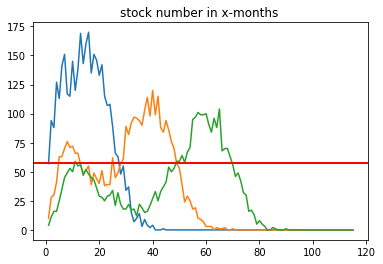

In [33]:
Class10_train,Class10_test=data_train_test(pct_chg_class1_data)
Class20_train,Class20_test=data_train_test(pct_chg_class2_data)
Class30_train,Class30_test=data_train_test(pct_chg_class3_data)

In [36]:
len(Class30_train)

162035

### 划分训练集/测试集

In [37]:
#数据标准化(不能处理空值)
def Standard1(X_train,X_test):
    from sklearn.preprocessing import MinMaxScaler
    scaler =MinMaxScaler()
    X_train_scaled =scaler.fit_transform(X_train)
    X_test_scaled =scaler.fit_transform(X_test)
    return  X_train_scaled,X_test_scaled 

In [38]:
# 可以处理空值
def Standard2(X_train,X_test):
    X_train_scaled =1.0 * (X_train - X_train.mean()) / X_train.std()  # 数据标准化
    X_test_scaled =1.0 * (X_test - X_test.mean()) / X_test.std()  # 数据标准化
    return  X_train_scaled,X_test_scaled 

In [39]:
#两分类划分，划分训练集data，测试集alldata（训练集的类别只有（0,1），测试集包含所有类别（0,1，-1））
def Splitdata2(data,alldata,i,j,x,y):
    #按月份计数
    resultdata=(data['stock'].groupby(data['date'])).describe()
    resultalldata=(alldata['stock'].groupby(alldata['date'])).describe()
    resultdata['sum']=resultdata['count'].cumsum()
    resultalldata['sum']=resultalldata['count'].cumsum()
    i=resultdata['sum'][i]
    j=resultdata['sum'][j]
    x=resultalldata['sum'][x]
    y=resultalldata['sum'][y]
    
    X_train=np.array(data[['risk_beta','risk_bp','risk_ey','risk_gro','risk_lev','risk_liq','risk_mom','risk_mv','risk_nlmv','risk_vol','stock','date']][j:i])
    Y_train=np.array(data['pct_chg_class'][j:i])
    #第x个月，测试集
    X_test=np.array(alldata[['risk_beta','risk_bp','risk_ey','risk_gro','risk_lev','risk_liq','risk_mom','risk_mv','risk_nlmv','risk_vol','stock','date']][x:y])
    Y_test=np.array(alldata['pct_chg_class'][x:y])
    X_train_scaled,X_test_scaled=Standard2(X_train[:,:-2],X_test[:,:-2])
    return X_train_scaled,X_test_scaled,Y_train,Y_test,X_test

In [40]:
#三类划分
def Splitdata3(data,i,j,x,y):
    #按月份计数
    resultdata=(data['stock'].groupby(data['date'])).describe()
    resultdata['sum']=resultdata['count'].cumsum()
    i=resultdata['sum'][i]
    j=resultdata['sum'][j]
    x=resultdata['sum'][x]
    y=resultdata['sum'][y]
    #j月-i月
    X_train=np.array(data[['risk_beta','risk_bp','risk_ey','risk_gro','risk_lev','risk_liq','risk_mom','risk_mv','risk_nlmv','risk_vol','stock','date']][j:i])
    Y_train=np.array(data['pct_chg_class'][j:i])
    #第x个月，测试集
    X_test=np.array(data[['risk_beta','risk_bp','risk_ey','risk_gro','risk_lev','risk_liq','risk_mom','risk_mv','risk_nlmv','risk_vol','stock','date']][x:y])
    Y_test=np.array(data['pct_chg_class'][x:y])
    X_train_scaled,X_test_scaled=Standard2(X_train[:,:-2],X_test[:,:-2])
    return X_train_scaled,X_test_scaled,Y_train,Y_test,X_test

## 预测概率

#### LR预测概率

In [41]:
from sklearn.linear_model import LogisticRegression
# 预测概率值（没有Y_test来检验）
def LR_probo(X_train,Y_train,X_test,Y_test,columns1,columns2,Xx_test):
    clf = LogisticRegression()  
    clf.fit(X_train, Y_train)  
    #   返回预测标签  
#     print(clf.predict(X_test))  
    probo=clf.predict_proba(X_test)
    # 返回预测属于某标签的概率  
    probo=pd.DataFrame(probo,columns=[columns1,columns2])
    probo['STOCK']=Xx_test[:,-2]
    probo['date']=Xx_test[:,-1]
#     probo['PCT_CHG']=Y_test
    return probo

#### SVM预测概率

In [42]:
from sklearn import svm
# 预测概率值（没有Y_test来检验）
def SVM_probo(X_train,Y_train,X_test,Y_test,columns1,columns2,Xx_test):
    clf = svm.SVC(probability=True)  
    clf.fit(X_train, Y_train)  
    #   返回预测标签  
#     print(clf.predict(X_test))  
    probo=clf.predict_proba(X_test)
    # 返回预测属于某标签的概率  
    probo=pd.DataFrame(probo,columns=[columns1,columns2])
    probo['STOCK']=Xx_test[:,-2]
    probo['date']=Xx_test[:,-1]
#     probo['PCT_CHG']=Y_test
    return probo

###### LightGBM

In [43]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

def LightGBM(data,X_train,y_train,X_test,y_test,Xx_test):
    lgb_train = lgb.Dataset(X_train, y_train)   # 创建成lgb特征的数据集格式
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    gbm = lgb.LGBMClassifier(boosting_type='gbdt',learning_rate = 0.01,num_leaves = 35,)
    gbm.fit(X_train,y_train)
#     print('Save model...')
#     # 保存模型到文件
#     gbm.save_model('model.txt')
#     print('Start predicting...')
    # 预测数据集
    y_pred=gbm.predict(X_test,num_iteration=gbm.best_iteration_)
    probo=gbm.predict_proba(X_test)
    probo=pd.DataFrame(probo)
    probo['stock']=Xx_test[:,-2]
    probo['date']=Xx_test[:,-1]
#     predict_proba(X)
    # 评估模型
    print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)
    
    ## 特征选择
#     df = pd.DataFrame(data.columns[1:11].tolist(), columns=['feature'])
#     df['importance']=list(gbm.feature_importance())
#     df = df.sort_values(by='importance',ascending=False)
#     df.to_csv("./data/feature_score_20180405.csv",index=None,encoding='gbk')
    return probo


#### 随机森林（评判特征值）

In [44]:
# # 随机森林（分类）随机森林的随机性促使算法考虑了更多可能的解释，这就导致随机森林捕获的数据比单一树要大得多
def RFC(X_train,Y_train,X_test,Y_test,columns1,columns2,Xx_test):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=20)
    clf = clf.fit(X_train, Y_train)
    probo=clf.predict_proba(X_test)     # 返回预测属于某标签的概率  
    probo=pd.DataFrame(probo,columns=[columns1,columns2])
    probo['STOCK']=Xx_test[:,-2]
    probo['date']=Xx_test[:,-1]
    print('Accuracy of randomforest regressor on train set:{:.3f}'.format(clf.score(X_train,Y_train)))       # 输出准确率
    print('Accuracy of randomforest regressor on test set:{:.3f}'.format(clf.score(X_test,Y_test)))
    from sklearn.metrics import classification_report
#     print(clf.predict(X_test))
    target_names = ['losing', 'active']
#     print(classification_report(Y_test,clf.predict(X_test), target_names=target_names))      
    plot_feature_importances(clf)    # 特征重要程度
    plt.show()
    
# 特征重要程度
def plot_feature_importances(model):
    adult_features=[x for i,x in enumerate(Class10_test.iloc[:,1:11].columns) if i !=10]
    plt.figure(figsize=(13,6))
    n_features=10
    plt.barh(range(n_features), model.feature_importances_,align='center')
    plt.yticks(np.arange(n_features), adult_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1,n_features)

#### 滚动预测

In [45]:
#从2009年4月来计算因子值，逐月扩展（以24个月为间隔滚动）,model：为预测模型：LR,SVM,RFC.....
def pct_probo(data_pct_drop_train,data_pct_test,model):
    allprobo_pct_df=[]
    for m in range(len(trade_date_m_list)-24):
        X_train, X_test, Y_train, Y_test,Xx_test= Splitdata2(data_pct_drop_train,data_pct_test,m+23,m,m+23,m+24)
        probo_pct=model(X_train,Y_train,X_test,Y_test,'1','-1',Xx_test)
        allprobo_pct_df.append(probo_pct)
    return allprobo_pct_df

In [118]:
#从2009年4月来计算因子值，逐月扩展（以24个月为间隔滚动）.
def pct_LightGBM_probo(data,alldata):
    allprobo_pct_df=[]
    for m in range(len(trade_date_m_list)-24):
        X_train, X_test, Y_train, Y_test,Xx_test= Splitdata2(data,alldata,m+23,m,m+23,m+24)
        probo_pct=LightGBM(data,X_train,Y_train,X_test,Y_test,Xx_test)
        allprobo_pct_df.append(probo_pct)
    return allprobo_pct_df

In [119]:
# lightgbm二分类
lightgbm2_probo10_df=pct_LightGBM_probo(Class10_train,Class10_test)
lightgbm2_probo20_df=pct_LightGBM_probo(Class20_train,Class20_test)
lightgbm2_probo30_df=pct_LightGBM_probo(Class30_train,Class30_test)

The rmse of prediction is: 1.07326837162
The rmse of prediction is: 1.10965098171
The rmse of prediction is: 1.07661084385
The rmse of prediction is: 1.04154963213
The rmse of prediction is: 1.05646440829
The rmse of prediction is: 1.1069737957
The rmse of prediction is: 1.05397232612
The rmse of prediction is: 1.10673035153
The rmse of prediction is: 1.11534829124
The rmse of prediction is: 1.08174176787
The rmse of prediction is: 1.07681778491
The rmse of prediction is: 1.06192211175
The rmse of prediction is: 1.09676433285
The rmse of prediction is: 1.07915149763
The rmse of prediction is: 1.0663095676
The rmse of prediction is: 1.0865525243
The rmse of prediction is: 1.0880620815
The rmse of prediction is: 1.04600547173
The rmse of prediction is: 1.05168819192
The rmse of prediction is: 1.10497682454
The rmse of prediction is: 1.07841762639
The rmse of prediction is: 1.08570253753
The rmse of prediction is: 1.05501218314
The rmse of prediction is: 1.06996751025
The rmse of predicti

The rmse of prediction is: 1.39376173906
The rmse of prediction is: 1.2238085545
The rmse of prediction is: 1.2683650894
The rmse of prediction is: 1.13656085344
The rmse of prediction is: 1.24146310474
The rmse of prediction is: 1.25256040294
The rmse of prediction is: 1.17479844557
The rmse of prediction is: 1.2314501998
The rmse of prediction is: 1.24457278788
The rmse of prediction is: 1.19007482283
The rmse of prediction is: 1.25351811305
The rmse of prediction is: 1.2102399973
The rmse of prediction is: 1.12827282698
The rmse of prediction is: 1.12481964876
The rmse of prediction is: 1.21138174945
The rmse of prediction is: 1.25030471275
The rmse of prediction is: 1.24584780456
The rmse of prediction is: 1.19466054714
The rmse of prediction is: 1.13629273451
The rmse of prediction is: 1.31867486298
The rmse of prediction is: 1.13400225886
The rmse of prediction is: 1.0988807919
The rmse of prediction is: 1.28443972522
The rmse of prediction is: 1.29962773826
The rmse of predictio

In [ ]:
# 模型选择：SVM_probo，LR_probo

In [47]:
LR_probo10_df=pct_probo(Class10_train,Class10_test,LR_probo)
LR_probo20_df=pct_probo(Class20_train,Class20_test,LR_probo)
LR_probo30_df=pct_probo(Class30_train,Class30_test,LR_probo)

In [108]:
SVM_probo10_df=pct_probo(Class10_train,Class10_test,SVM_probo)
SVM_probo20_df=pct_probo(Class20_train,Class20_test,SVM_probo)
SVM_probo30_df=pct_probo(Class30_train,Class30_test,SVM_probo)

In [48]:
# lightgbm三分类
lightgbm_probo10_df=pct_LightGBM_probo(Class10_test)
lightgbm_probo20_df=pct_LightGBM_probo(Class20_test)
lightgbm_probo30_df=pct_LightGBM_probo(Class30_test)

The rmse of prediction is: 0.445439811235
The rmse of prediction is: 0.447752082866
The rmse of prediction is: 0.447969845628
The rmse of prediction is: 0.449106349013
The rmse of prediction is: 0.421220662196
The rmse of prediction is: 0.446801986029
The rmse of prediction is: 0.450567363338
The rmse of prediction is: 0.421325044235
The rmse of prediction is: 0.44883027893
The rmse of prediction is: 0.424253541459
The rmse of prediction is: 0.44781107552
The rmse of prediction is: 0.450198368976
The rmse of prediction is: 0.443357359084
The rmse of prediction is: 0.445462480504
The rmse of prediction is: 0.447796791047
The rmse of prediction is: 0.446179356851
The rmse of prediction is: 0.447963954409
The rmse of prediction is: 0.448050987757
The rmse of prediction is: 0.430794722335
The rmse of prediction is: 0.430331482912
The rmse of prediction is: 0.449630481419
The rmse of prediction is: 0.443001128667
The rmse of prediction is: 0.446655624484
The rmse of prediction is: 0.4435482

The rmse of prediction is: 0.807358014428
The rmse of prediction is: 0.809266234802
The rmse of prediction is: 0.807090609522
The rmse of prediction is: 0.783529710323
The rmse of prediction is: 0.834892424188
The rmse of prediction is: 0.788358396966
The rmse of prediction is: 0.813685033249
The rmse of prediction is: 0.767968463609
The rmse of prediction is: 0.793179379884
The rmse of prediction is: 0.812972551657
The rmse of prediction is: 0.774922335293
The rmse of prediction is: 0.80302426674
The rmse of prediction is: 0.82304658457
The rmse of prediction is: 0.80692215074
The rmse of prediction is: 0.83054265411
The rmse of prediction is: 0.798669105716
The rmse of prediction is: 0.787960323857
The rmse of prediction is: 0.817278291572
The rmse of prediction is: 0.831606446666
The rmse of prediction is: 0.829013604301
The rmse of prediction is: 0.84933357485
The rmse of prediction is: 0.865963052699
The rmse of prediction is: 0.828698840209
The rmse of prediction is: 0.8483845294

###### 随机森林特征值重要程度

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.112


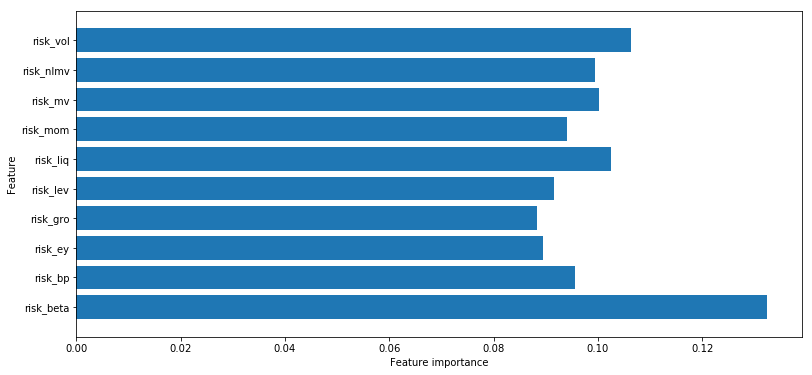

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.104


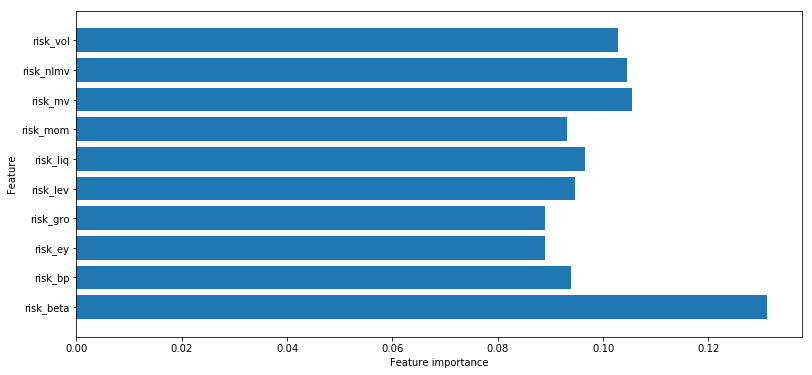

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.103


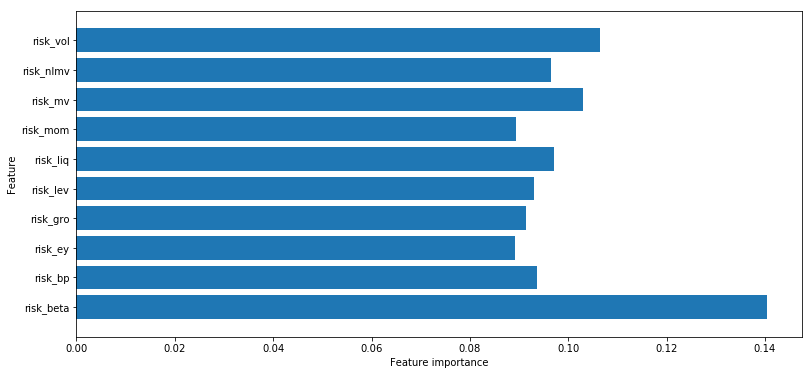

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.116


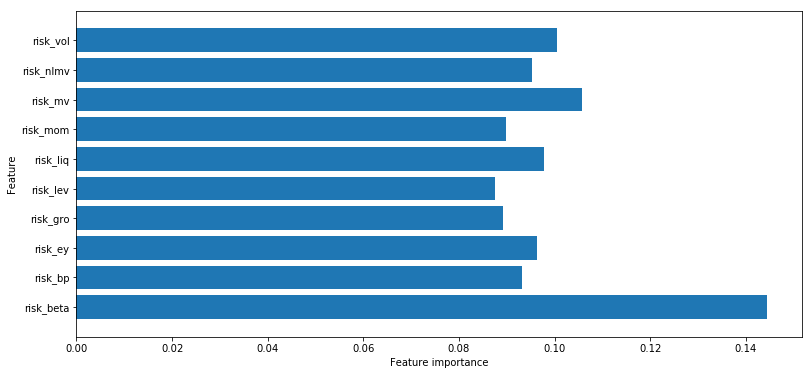

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.092


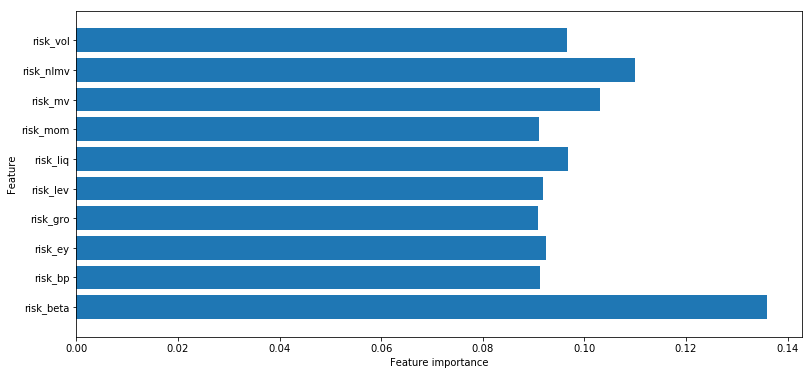

Accuracy of randomforest regressor on train set:0.979
Accuracy of randomforest regressor on test set:0.086


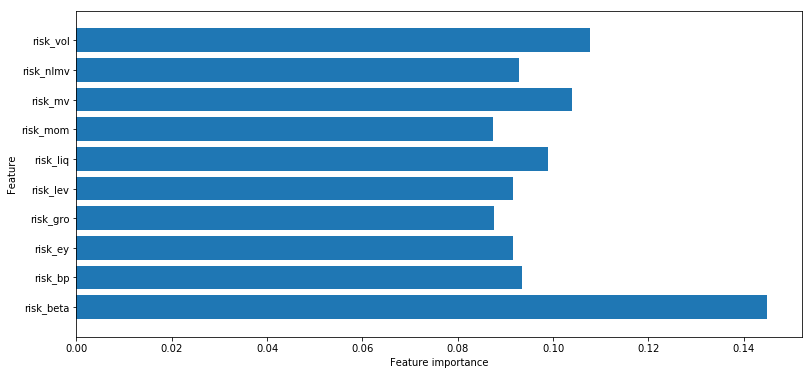

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.104


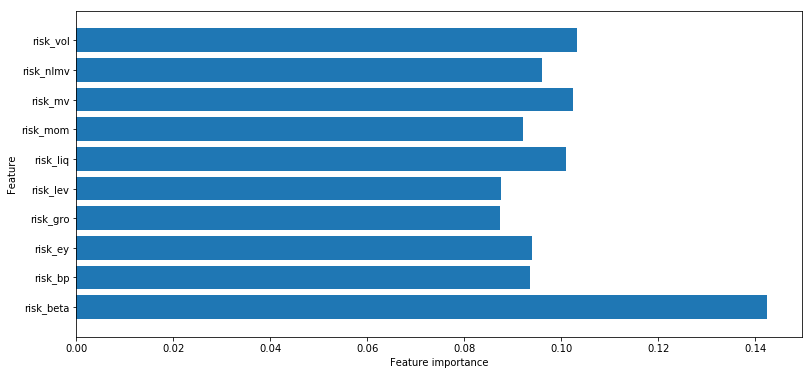

Accuracy of randomforest regressor on train set:0.979
Accuracy of randomforest regressor on test set:0.086


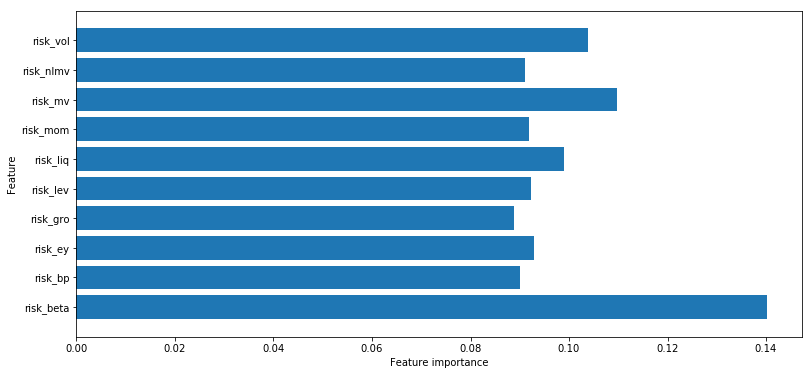

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.103


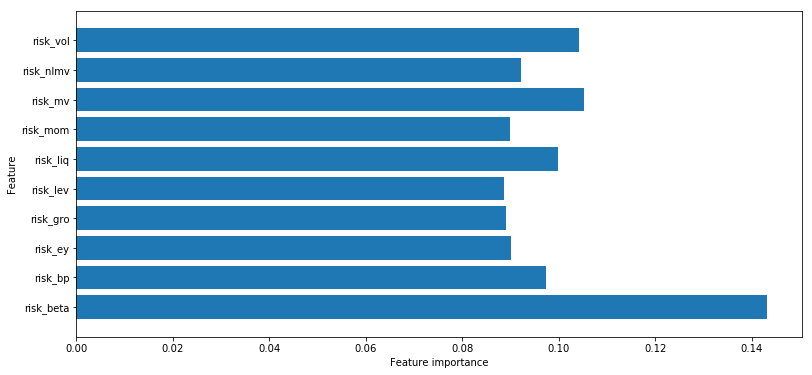

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.096


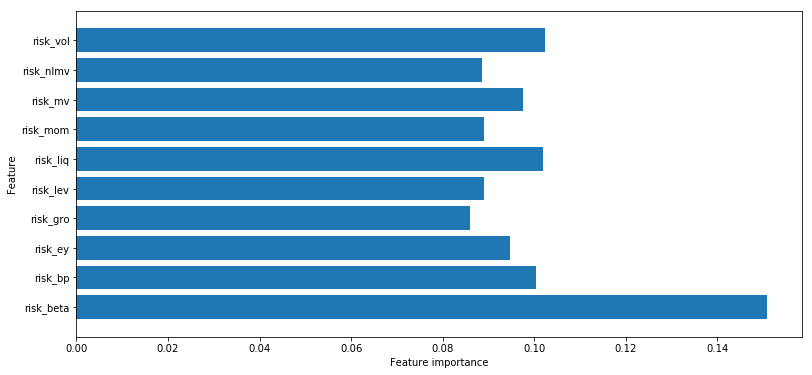

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.107


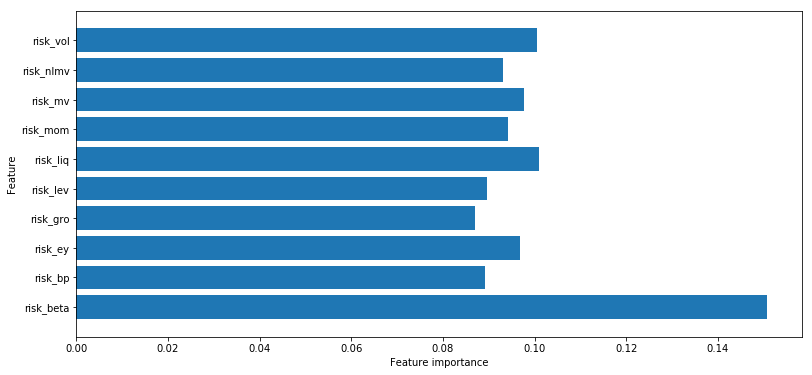

Accuracy of randomforest regressor on train set:0.977
Accuracy of randomforest regressor on test set:0.104


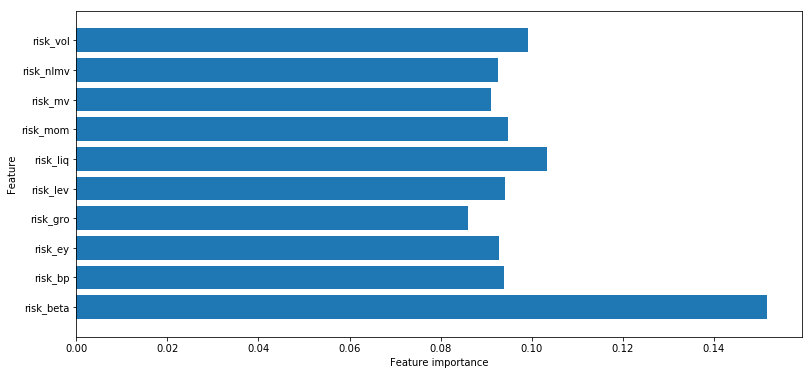

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.098


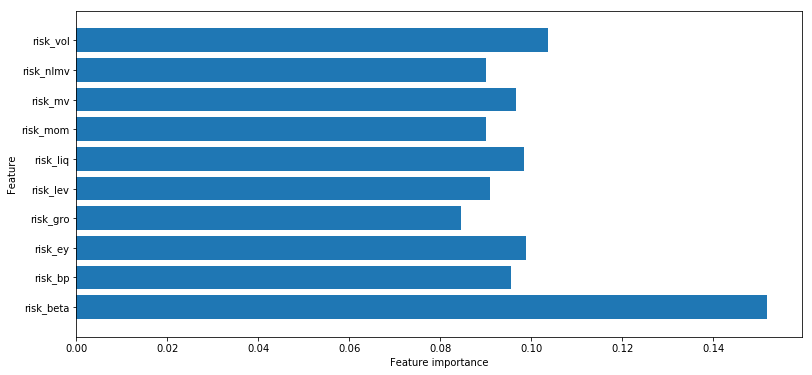

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.109


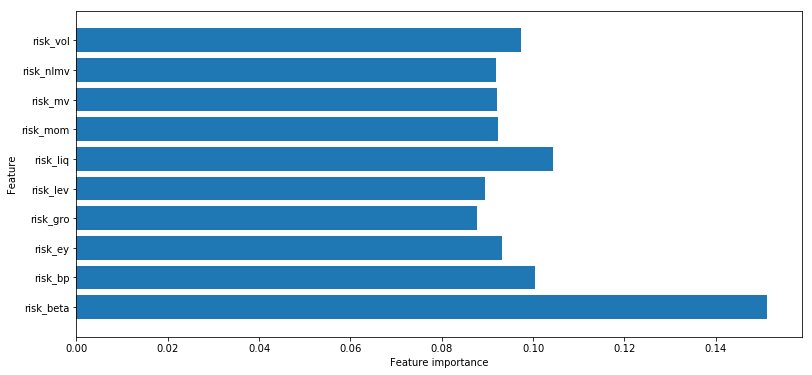

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.099


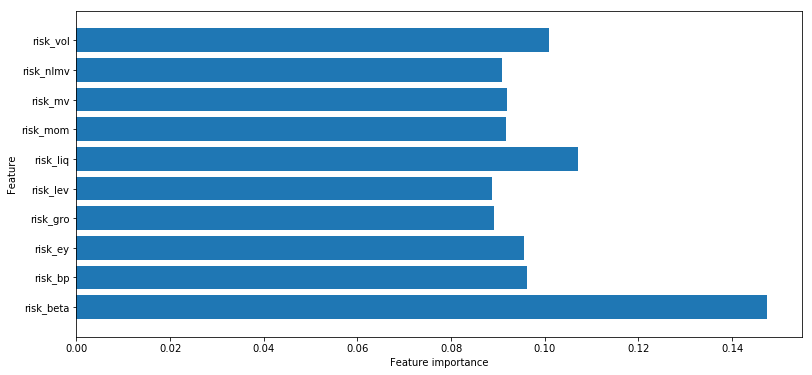

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.107


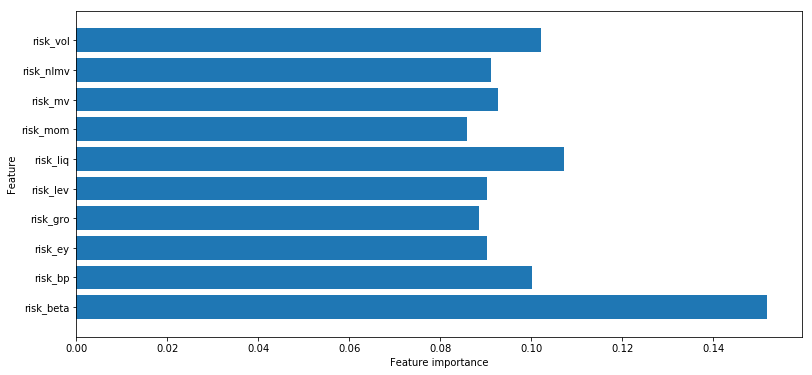

Accuracy of randomforest regressor on train set:0.979
Accuracy of randomforest regressor on test set:0.104


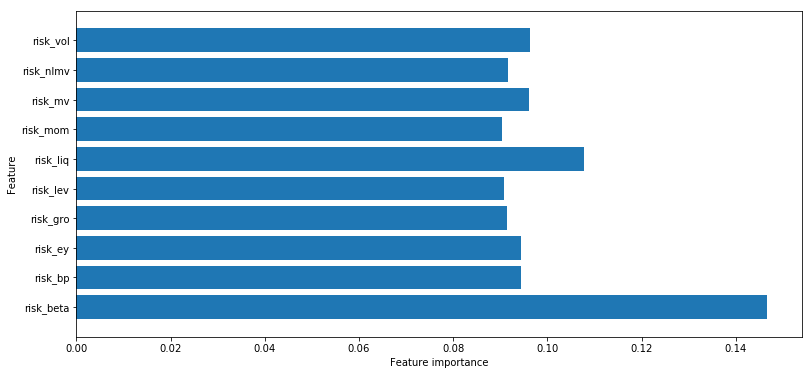

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.115


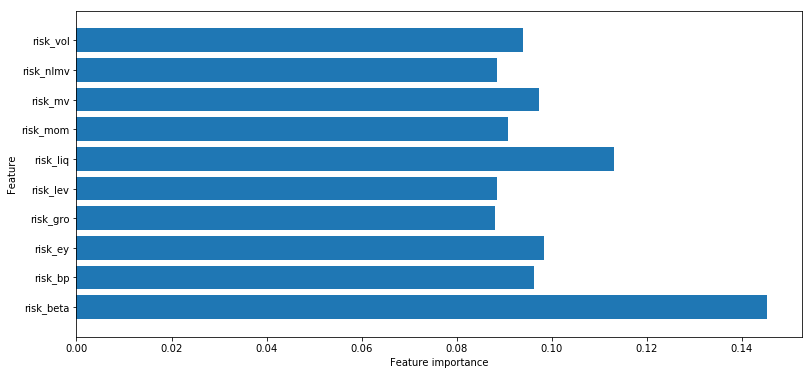

Accuracy of randomforest regressor on train set:0.977
Accuracy of randomforest regressor on test set:0.101


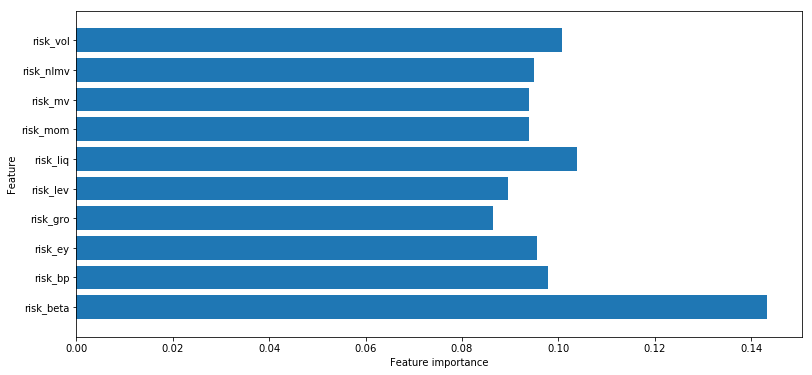

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.084


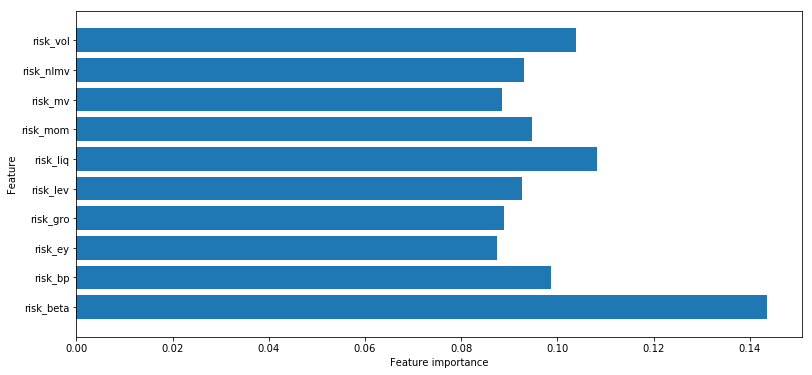

Accuracy of randomforest regressor on train set:0.979
Accuracy of randomforest regressor on test set:0.107


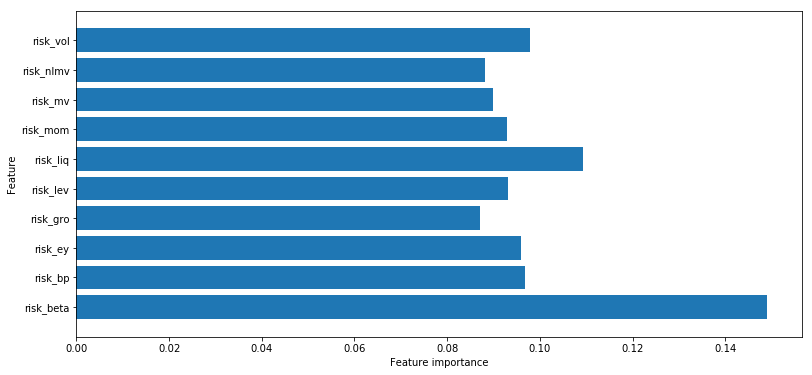

Accuracy of randomforest regressor on train set:0.977
Accuracy of randomforest regressor on test set:0.104


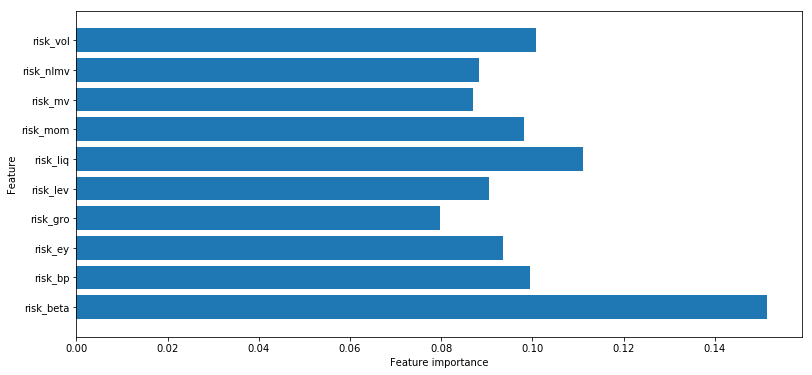

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.118


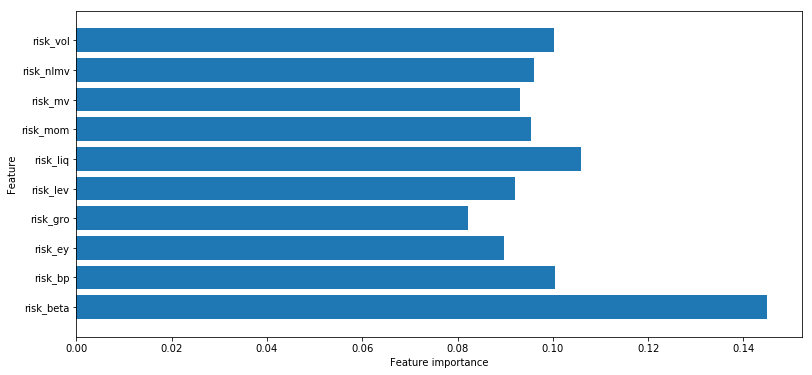

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.100


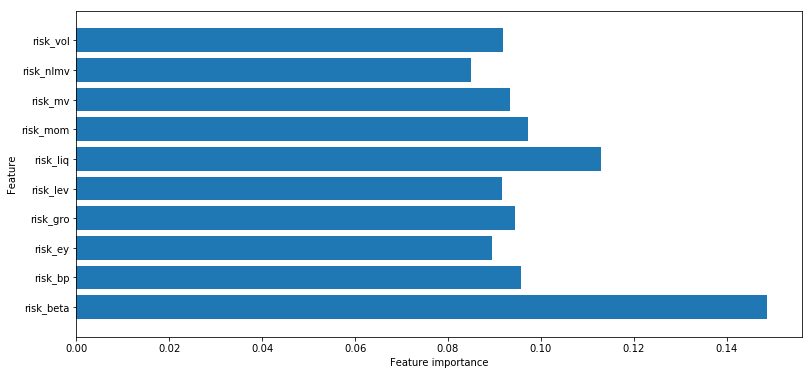

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.092


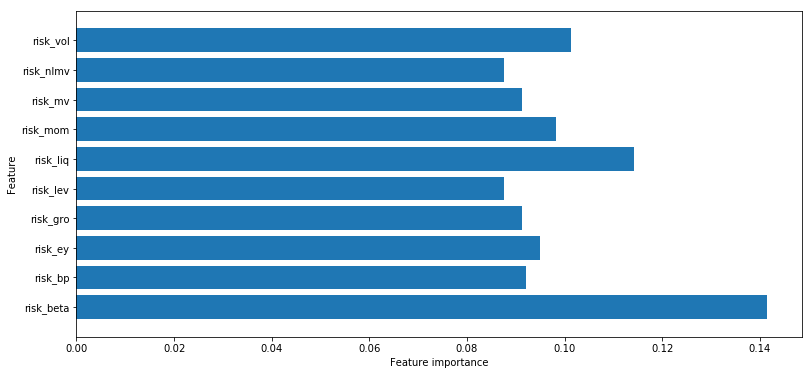

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.097


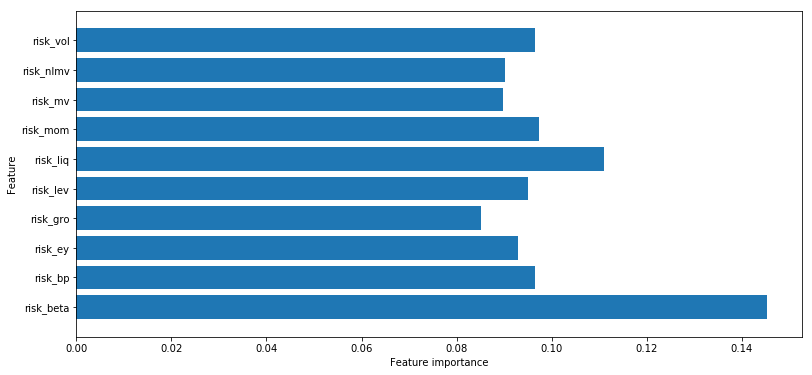

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.112


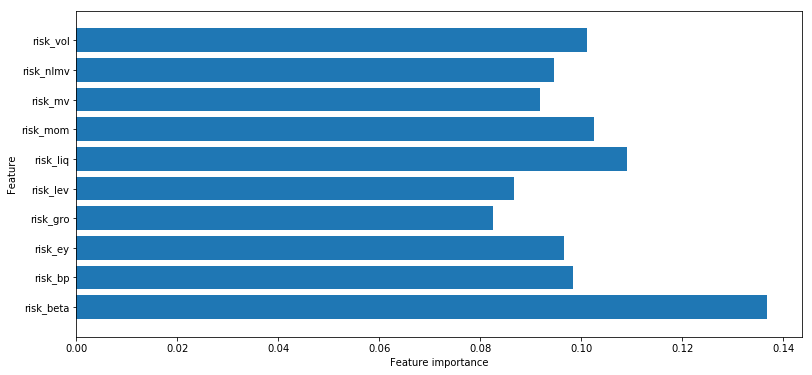

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.117


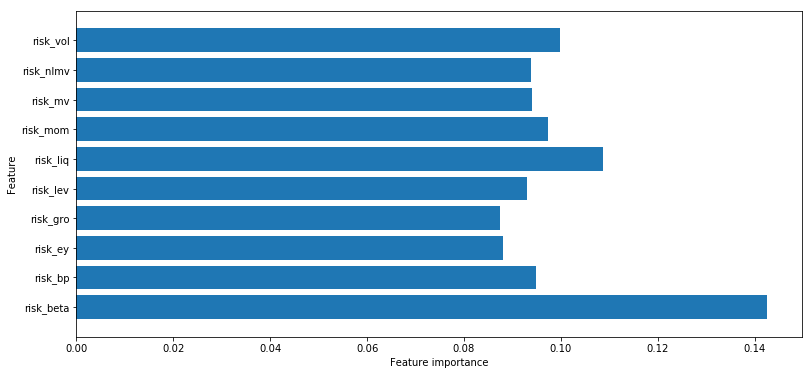

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.106


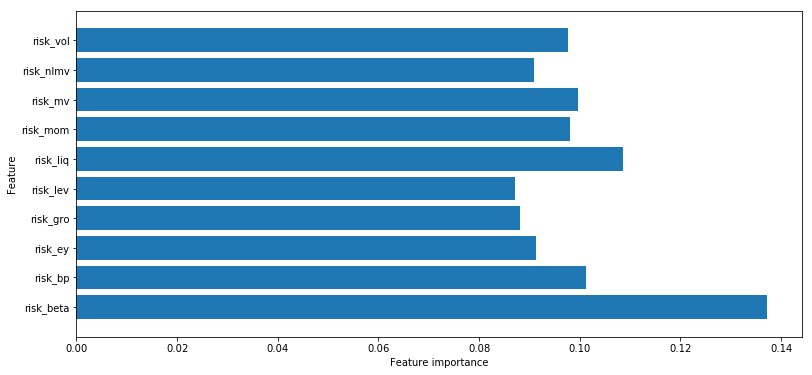

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.105


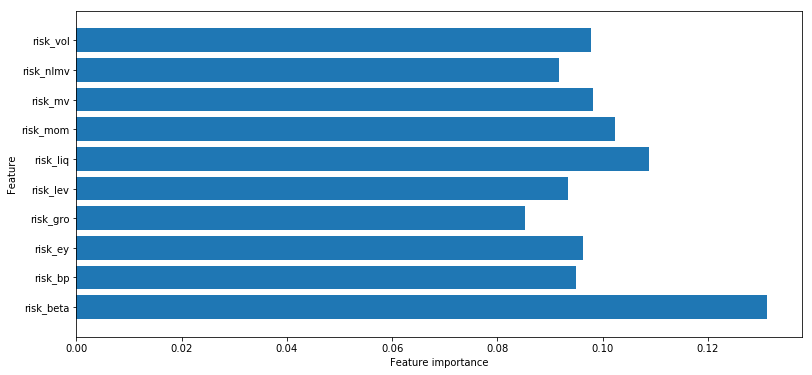

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.109


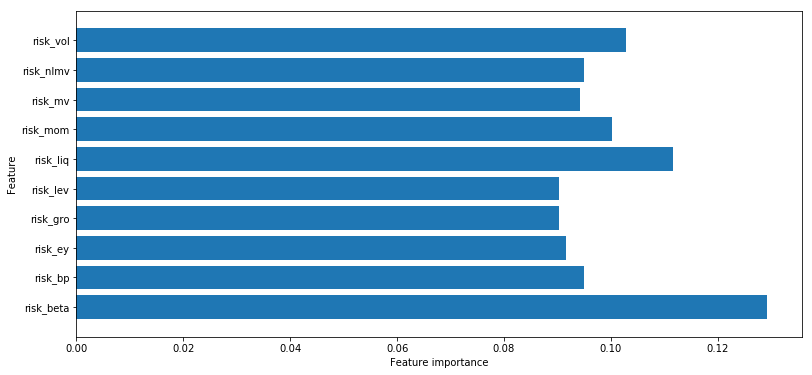

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.115


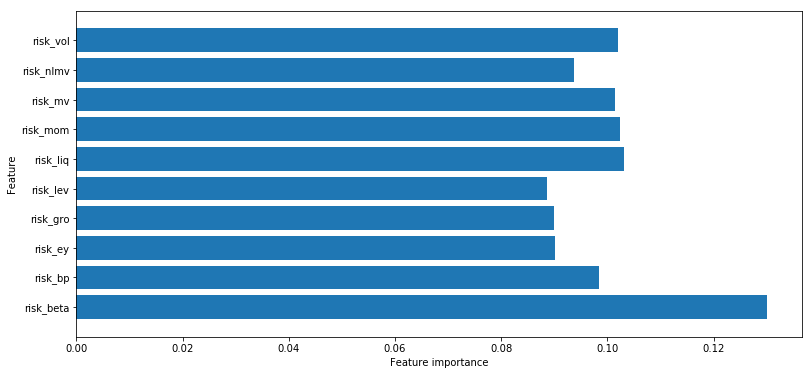

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.115


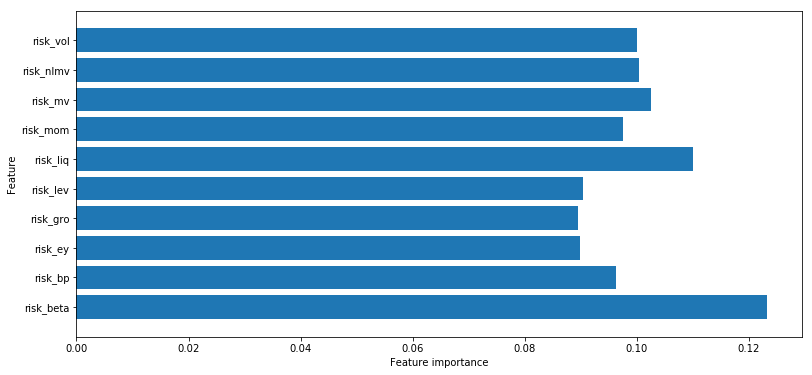

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.119


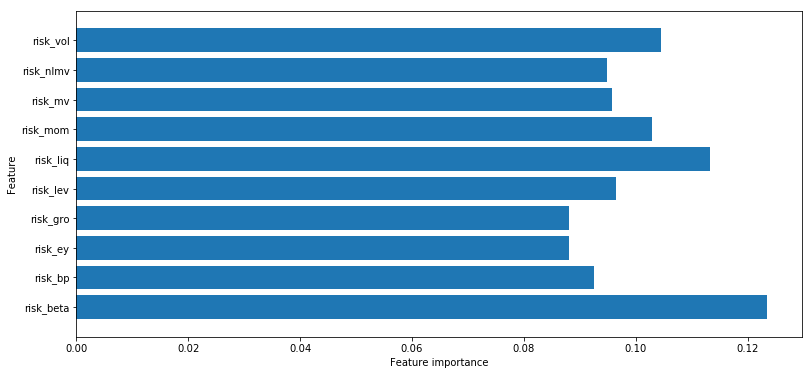

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.113


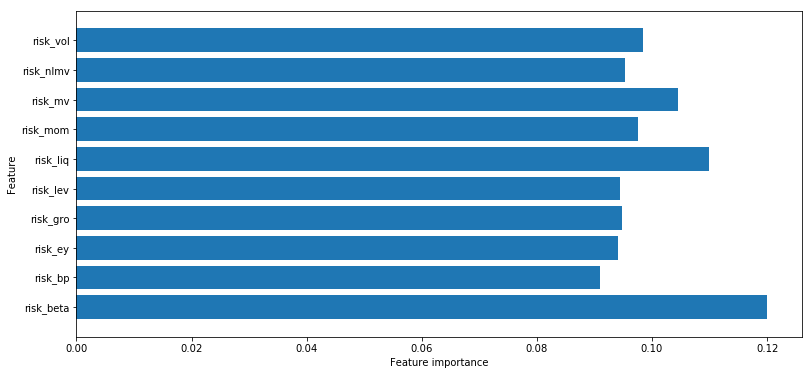

Accuracy of randomforest regressor on train set:0.983
Accuracy of randomforest regressor on test set:0.110


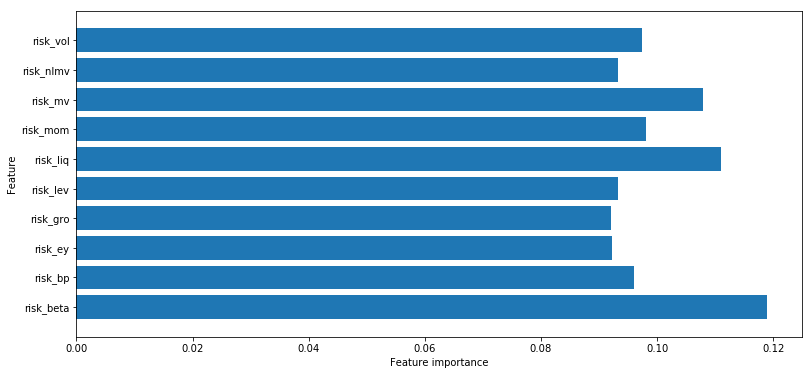

Accuracy of randomforest regressor on train set:0.982
Accuracy of randomforest regressor on test set:0.102


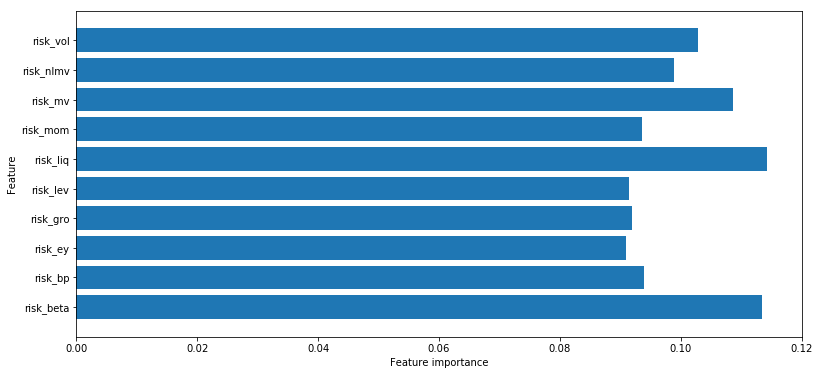

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.118


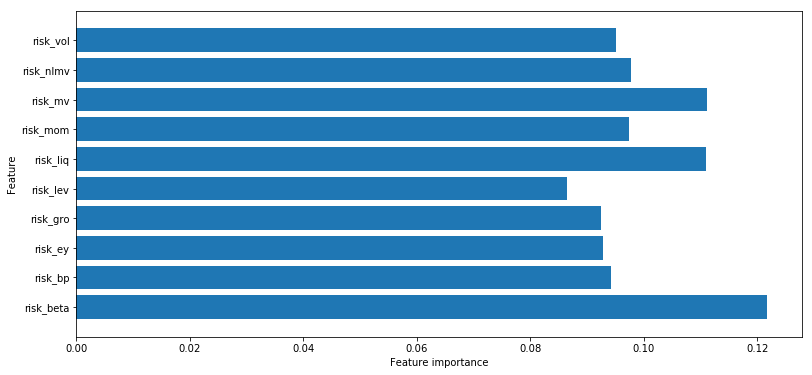

Accuracy of randomforest regressor on train set:0.982
Accuracy of randomforest regressor on test set:0.109


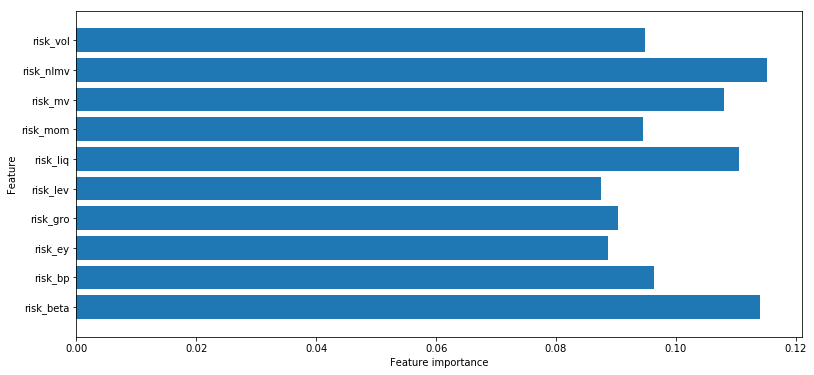

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.124


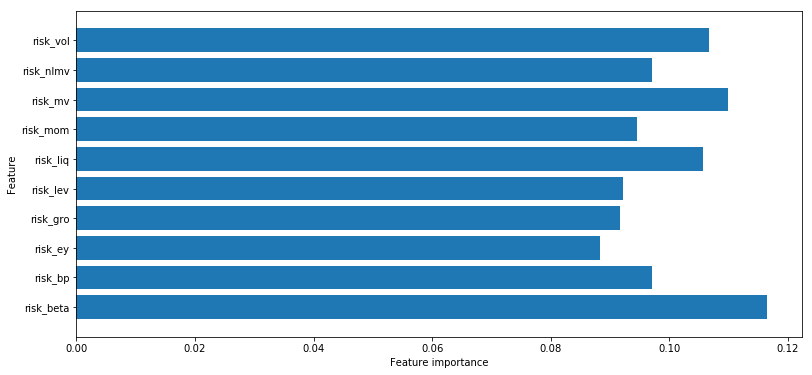

Accuracy of randomforest regressor on train set:0.979
Accuracy of randomforest regressor on test set:0.109


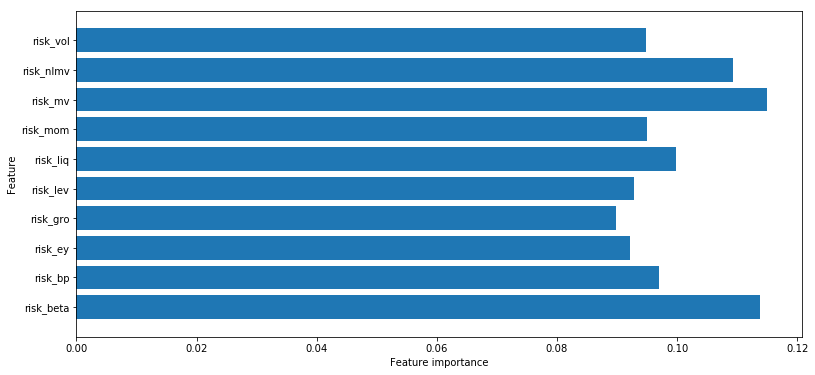

Accuracy of randomforest regressor on train set:0.983
Accuracy of randomforest regressor on test set:0.114


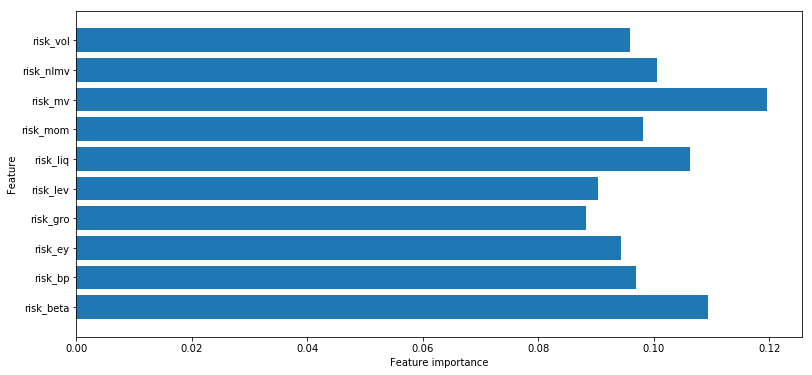

Accuracy of randomforest regressor on train set:0.982
Accuracy of randomforest regressor on test set:0.108


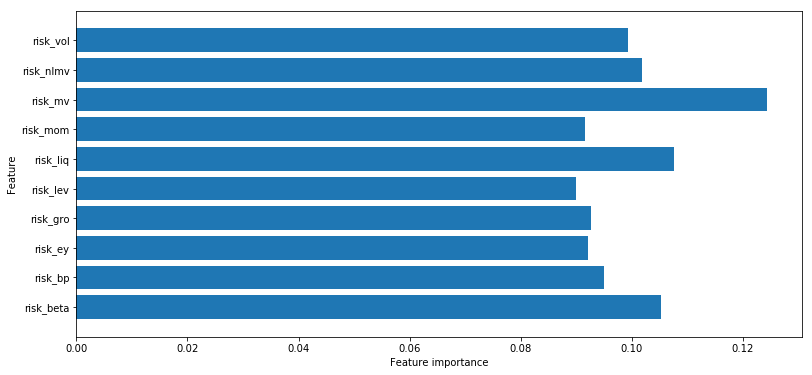

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.084


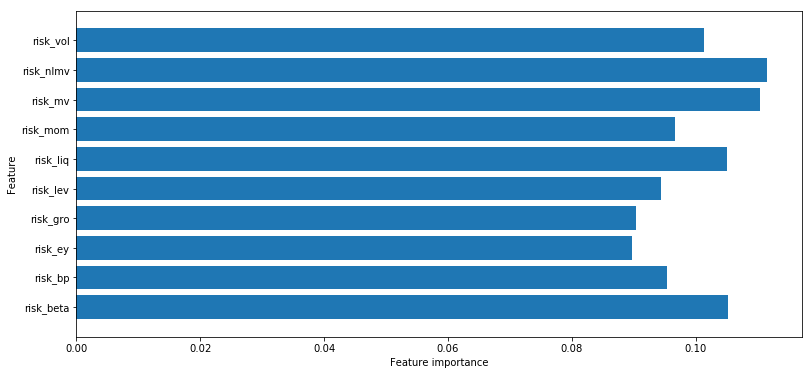

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.105


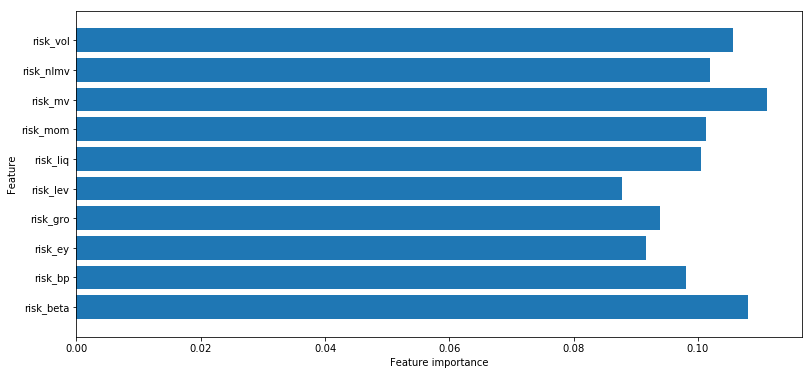

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.109


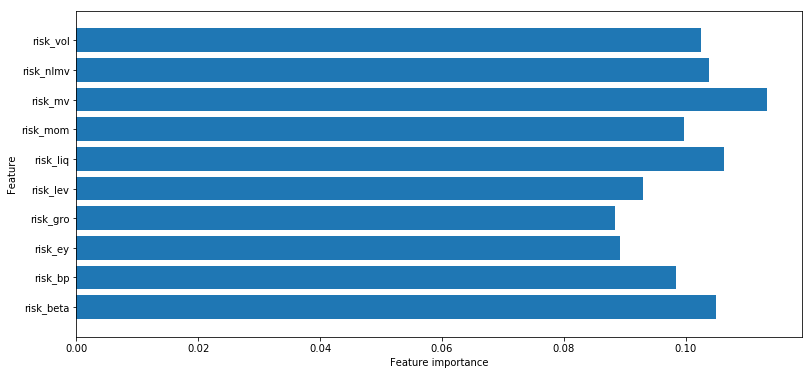

Accuracy of randomforest regressor on train set:0.983
Accuracy of randomforest regressor on test set:0.069


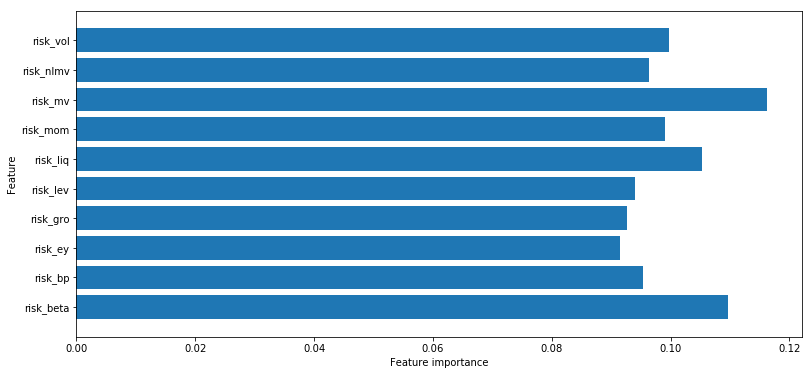

Accuracy of randomforest regressor on train set:0.982
Accuracy of randomforest regressor on test set:0.107


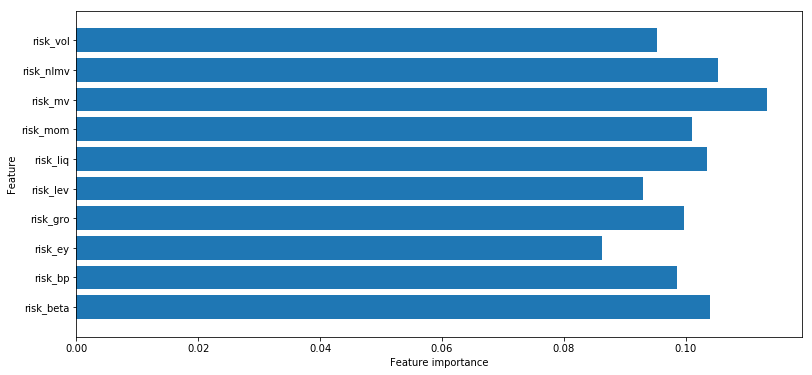

Accuracy of randomforest regressor on train set:0.979
Accuracy of randomforest regressor on test set:0.130


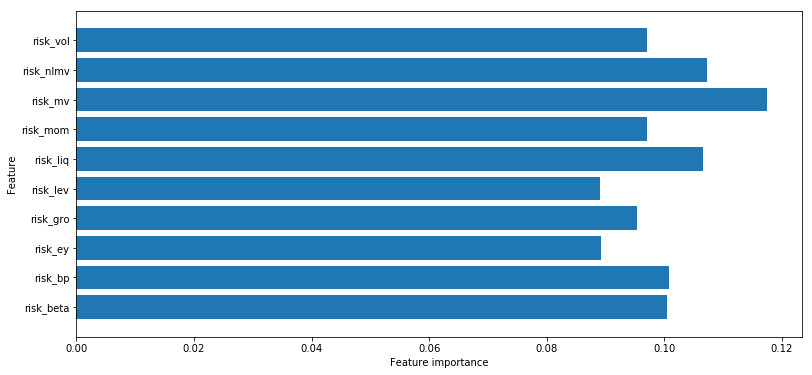

Accuracy of randomforest regressor on train set:0.983
Accuracy of randomforest regressor on test set:0.115


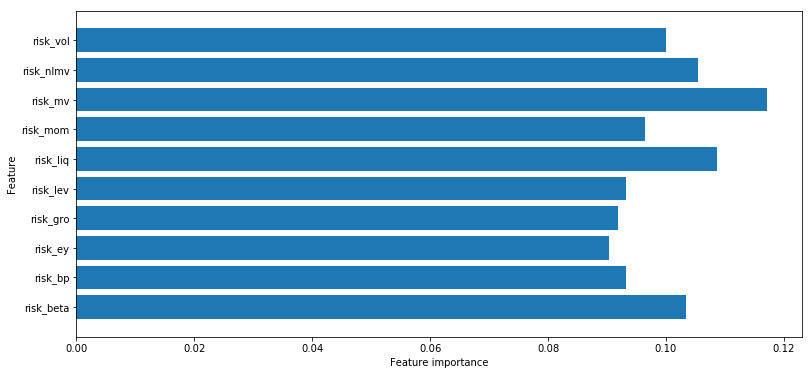

Accuracy of randomforest regressor on train set:0.981
Accuracy of randomforest regressor on test set:0.099


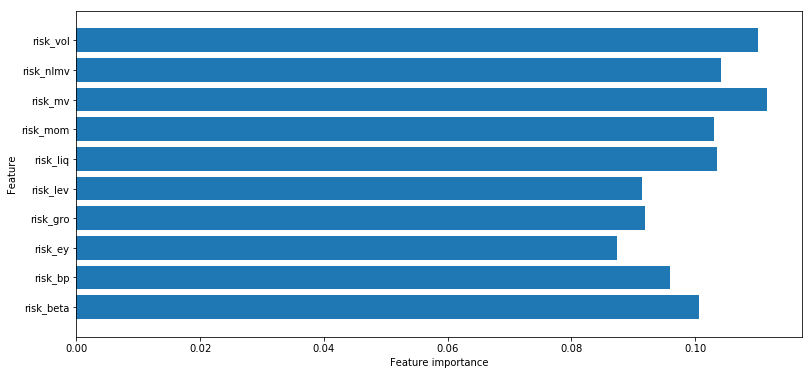

Accuracy of randomforest regressor on train set:0.979
Accuracy of randomforest regressor on test set:0.109


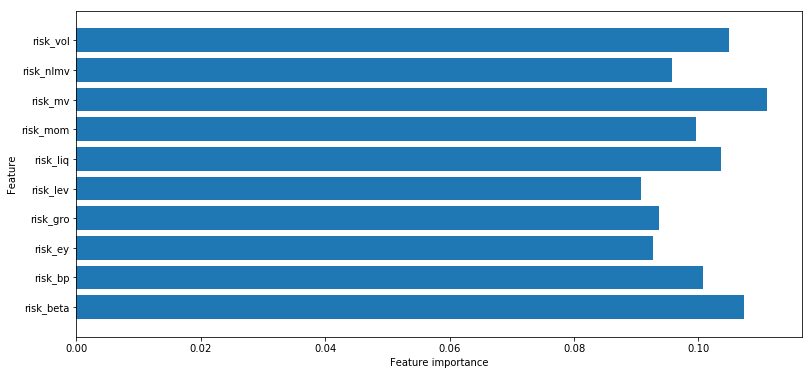

Accuracy of randomforest regressor on train set:0.977
Accuracy of randomforest regressor on test set:0.106


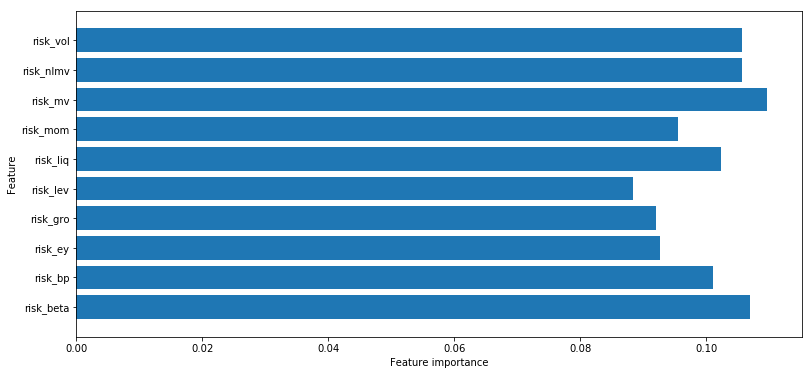

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.069


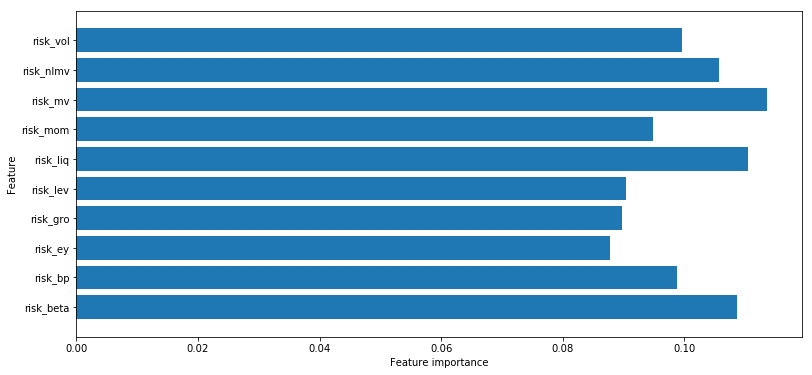

Accuracy of randomforest regressor on train set:0.977
Accuracy of randomforest regressor on test set:0.121


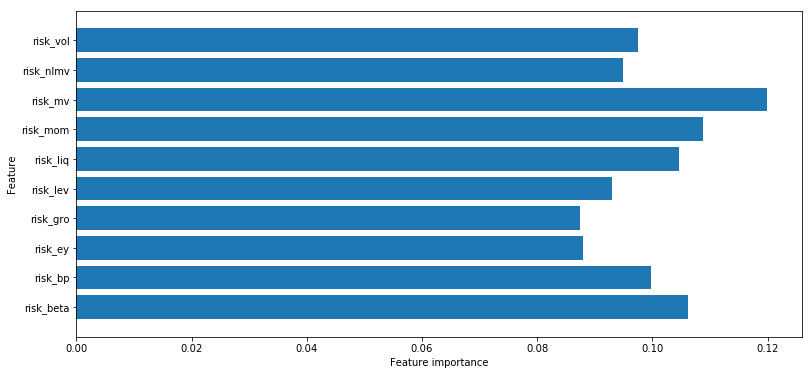

Accuracy of randomforest regressor on train set:0.977
Accuracy of randomforest regressor on test set:0.108


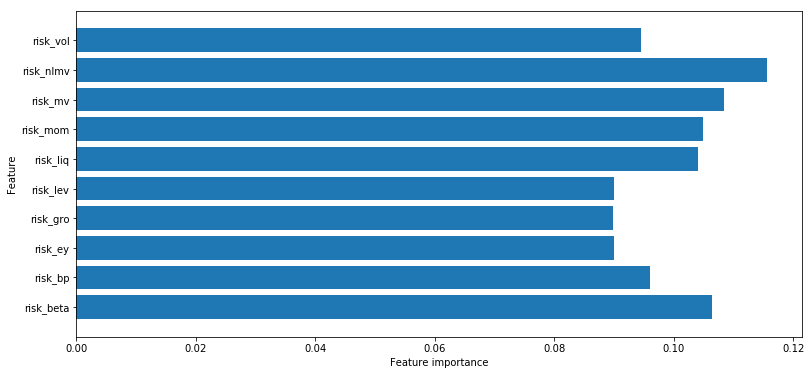

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.082


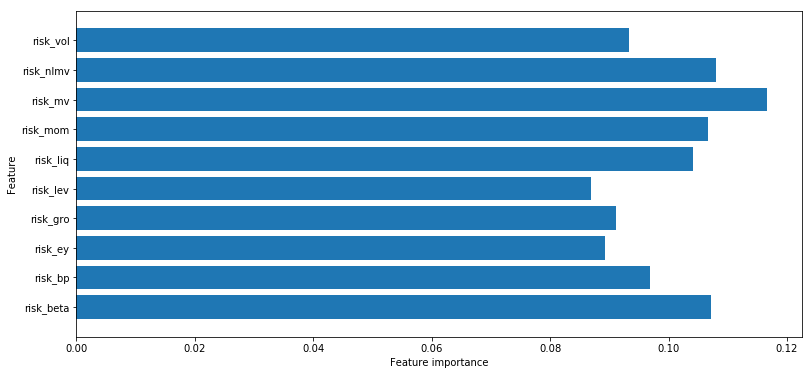

Accuracy of randomforest regressor on train set:0.982
Accuracy of randomforest regressor on test set:0.116


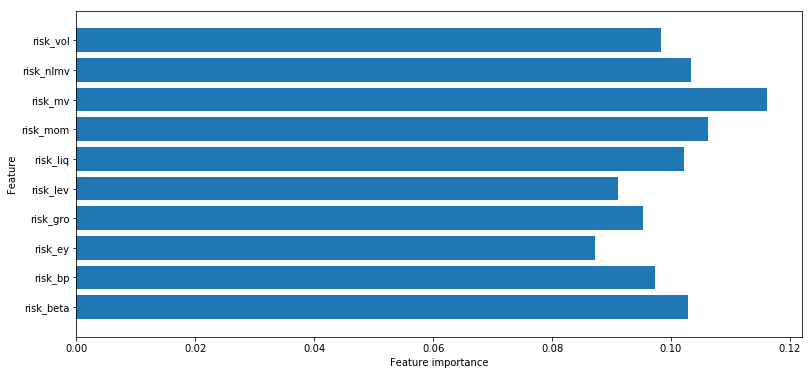

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.066


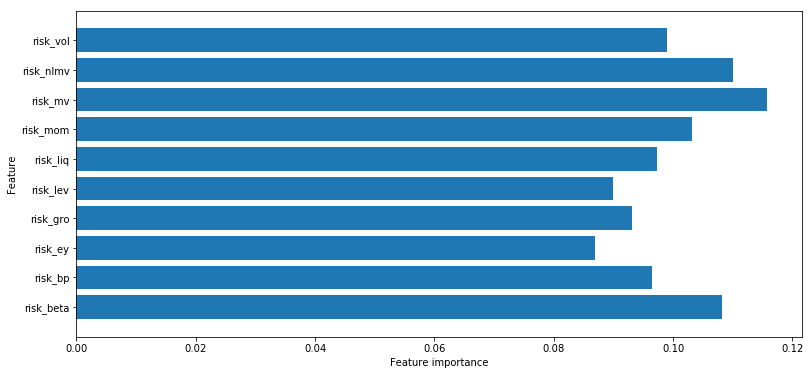

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.125


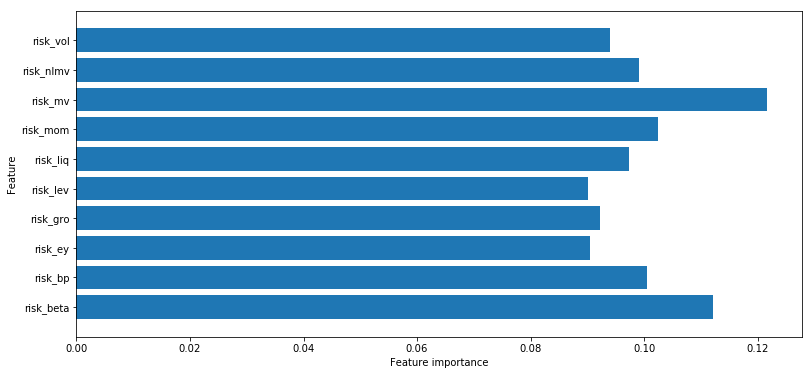

Accuracy of randomforest regressor on train set:0.982
Accuracy of randomforest regressor on test set:0.106


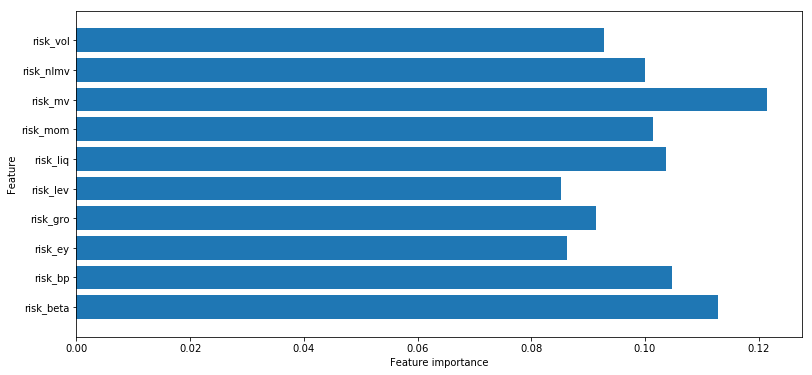

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.119


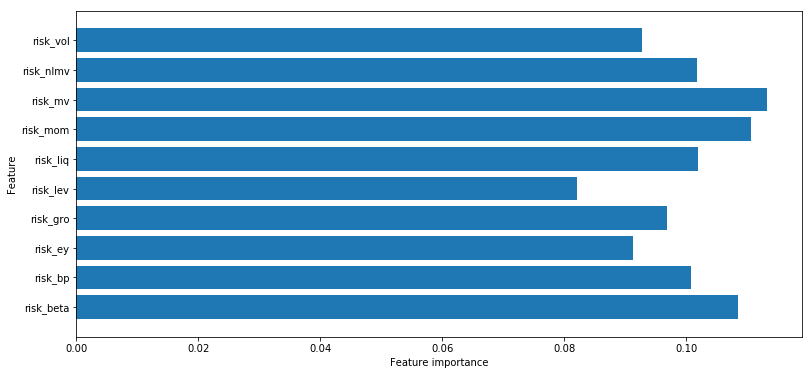

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.108


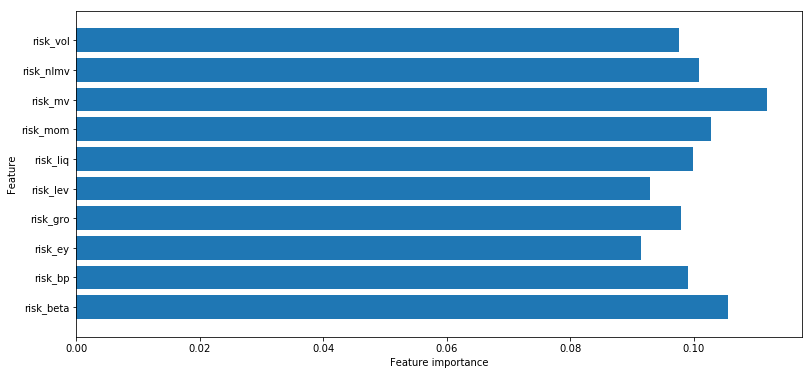

Accuracy of randomforest regressor on train set:0.980
Accuracy of randomforest regressor on test set:0.114


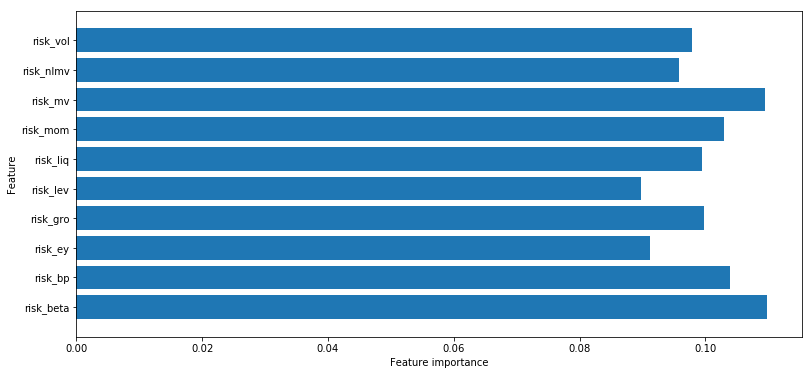

Accuracy of randomforest regressor on train set:0.977
Accuracy of randomforest regressor on test set:0.121


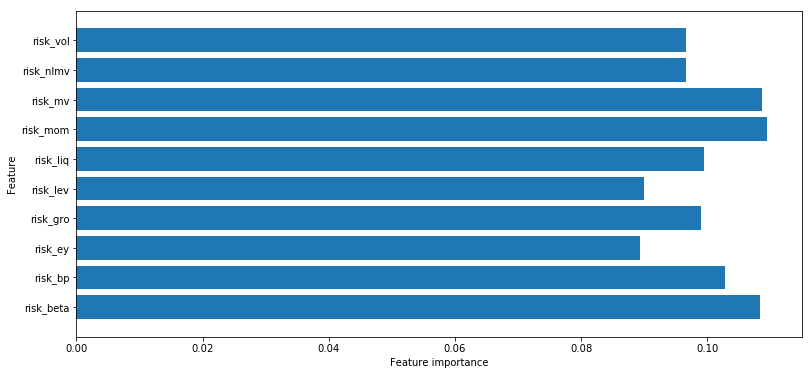

Accuracy of randomforest regressor on train set:0.979
Accuracy of randomforest regressor on test set:0.109


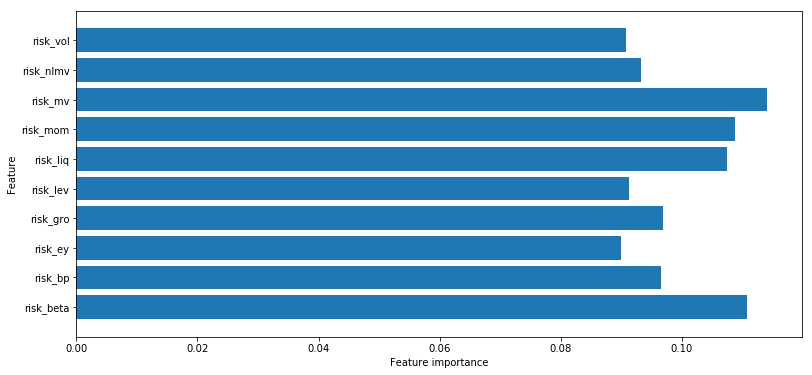

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.116


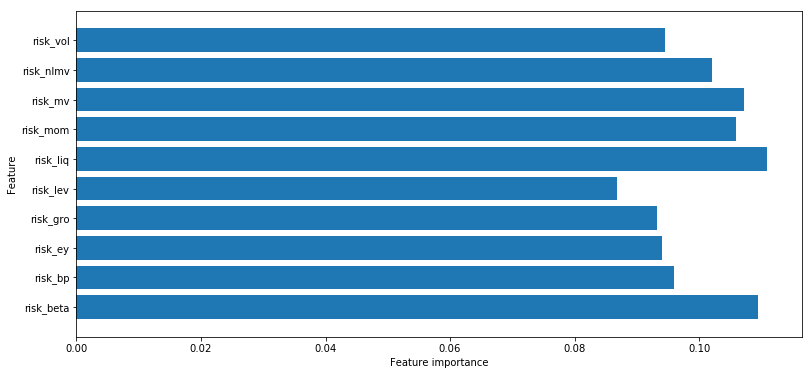

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.112


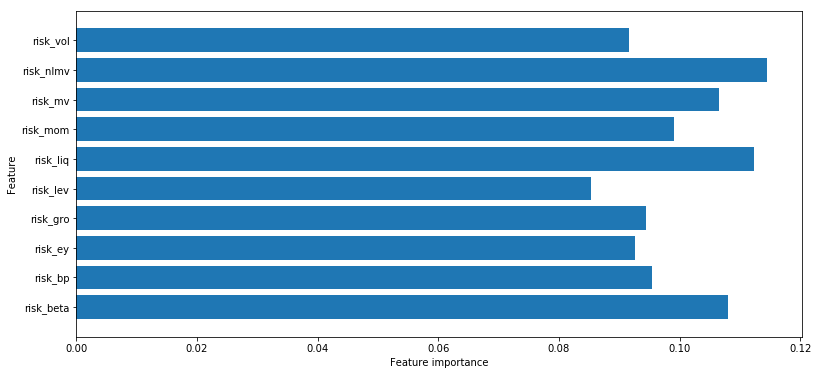

Accuracy of randomforest regressor on train set:0.974
Accuracy of randomforest regressor on test set:0.101


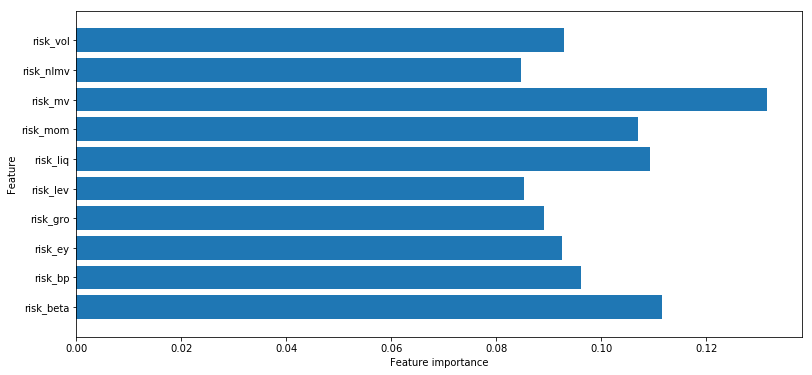

Accuracy of randomforest regressor on train set:0.975
Accuracy of randomforest regressor on test set:0.109


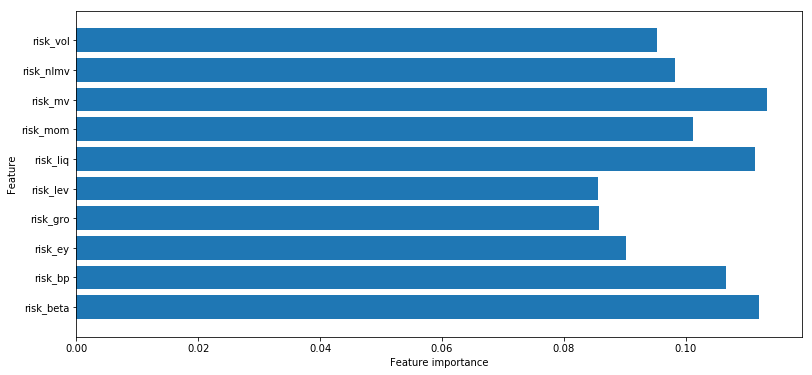

Accuracy of randomforest regressor on train set:0.976
Accuracy of randomforest regressor on test set:0.114


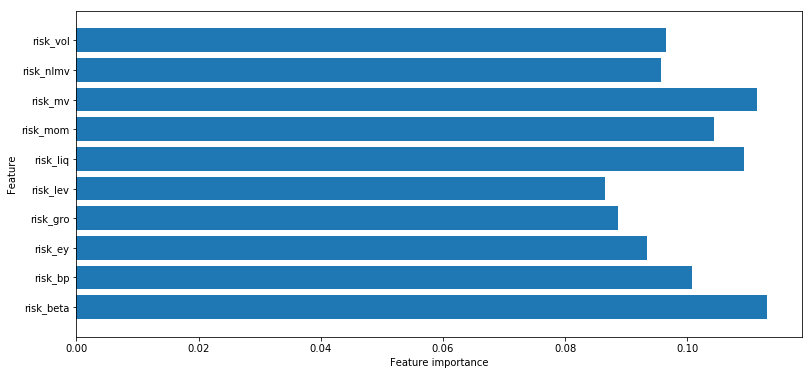

Accuracy of randomforest regressor on train set:0.974
Accuracy of randomforest regressor on test set:0.118


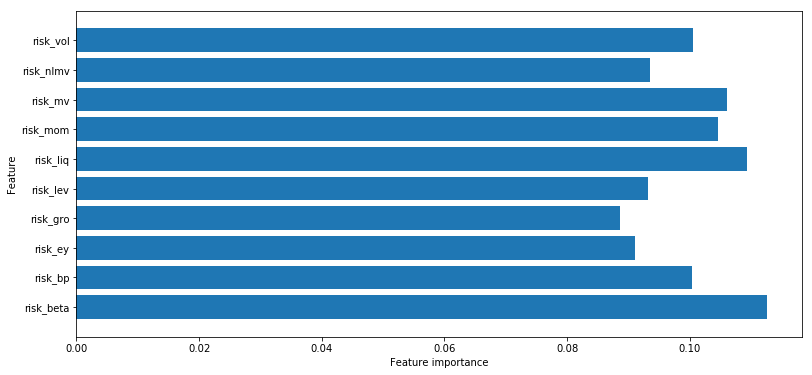

Accuracy of randomforest regressor on train set:0.974
Accuracy of randomforest regressor on test set:0.112


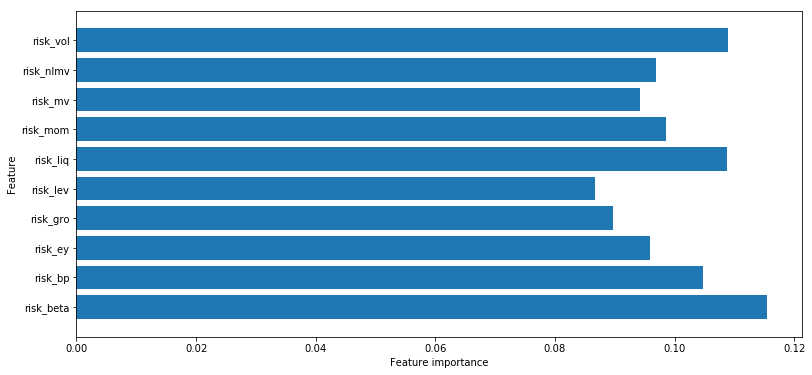

Accuracy of randomforest regressor on train set:0.978
Accuracy of randomforest regressor on test set:0.104


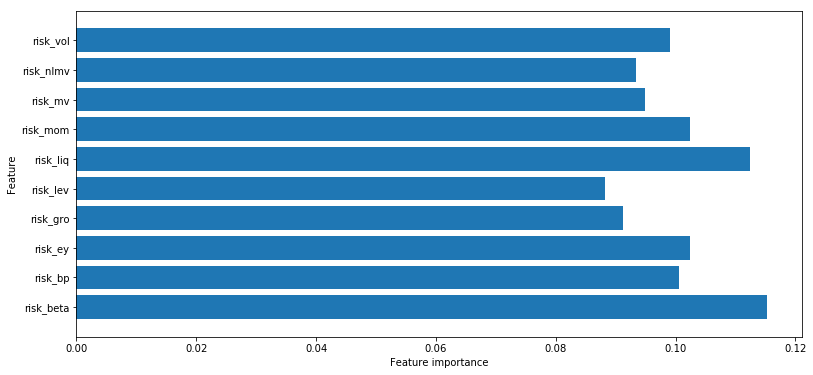

Accuracy of randomforest regressor on train set:0.973
Accuracy of randomforest regressor on test set:0.132


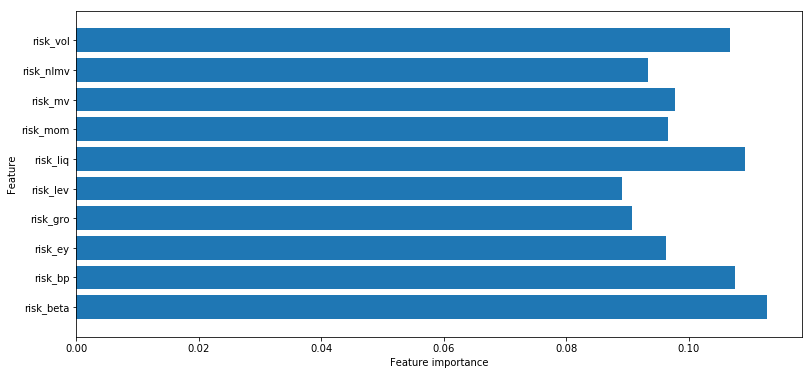

Accuracy of randomforest regressor on train set:0.974
Accuracy of randomforest regressor on test set:0.100


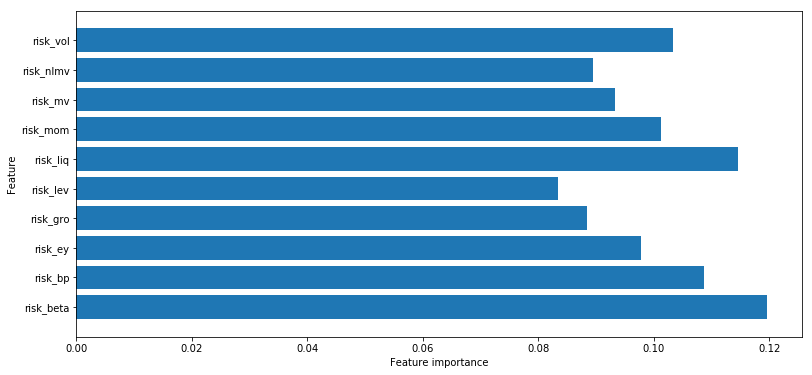

Accuracy of randomforest regressor on train set:0.974
Accuracy of randomforest regressor on test set:0.111


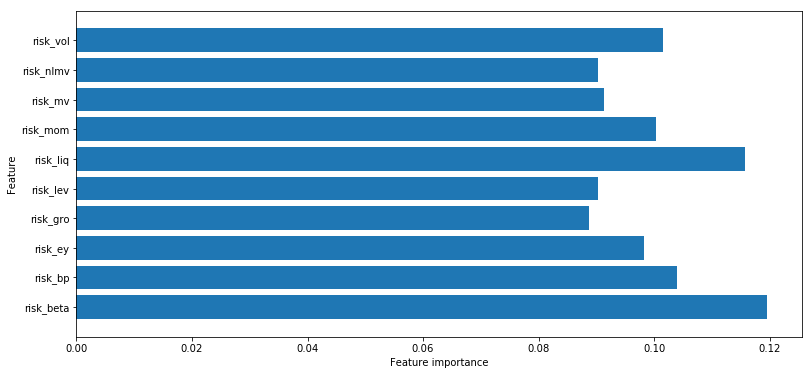

Accuracy of randomforest regressor on train set:0.974
Accuracy of randomforest regressor on test set:0.115


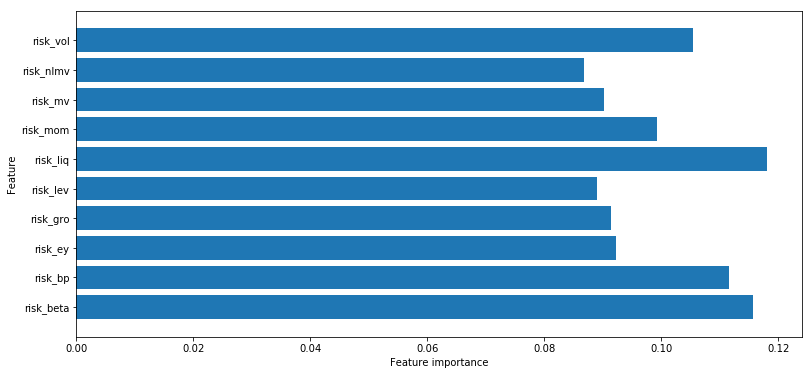

Accuracy of randomforest regressor on train set:0.973
Accuracy of randomforest regressor on test set:0.109


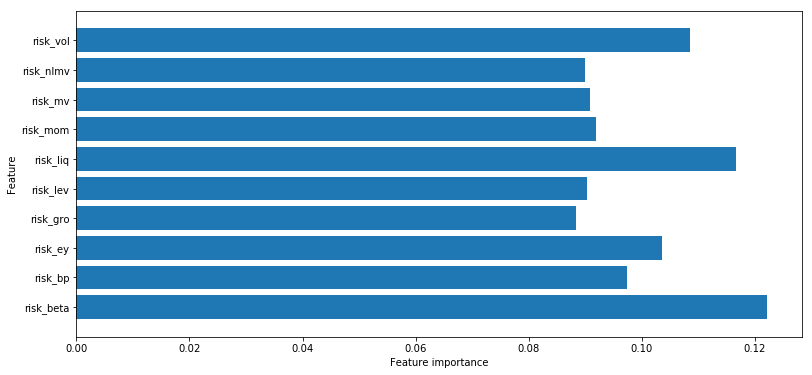

Accuracy of randomforest regressor on train set:0.973
Accuracy of randomforest regressor on test set:0.115


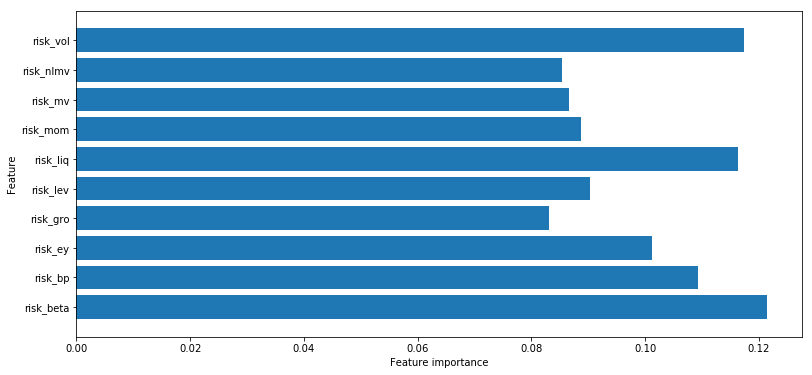

Accuracy of randomforest regressor on train set:0.973
Accuracy of randomforest regressor on test set:0.126


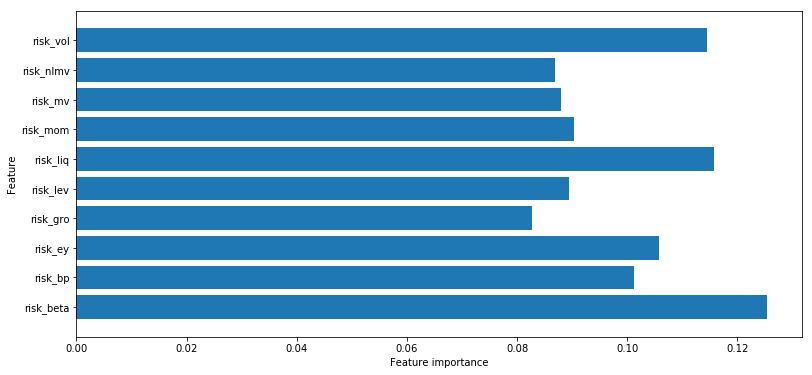

Accuracy of randomforest regressor on train set:0.973
Accuracy of randomforest regressor on test set:0.097


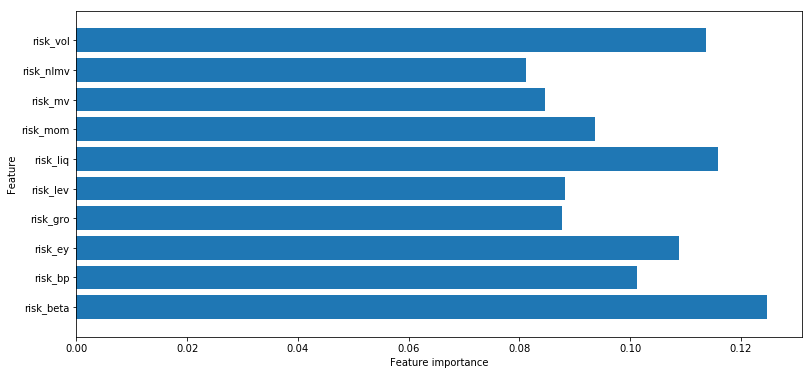

Accuracy of randomforest regressor on train set:0.973
Accuracy of randomforest regressor on test set:0.086


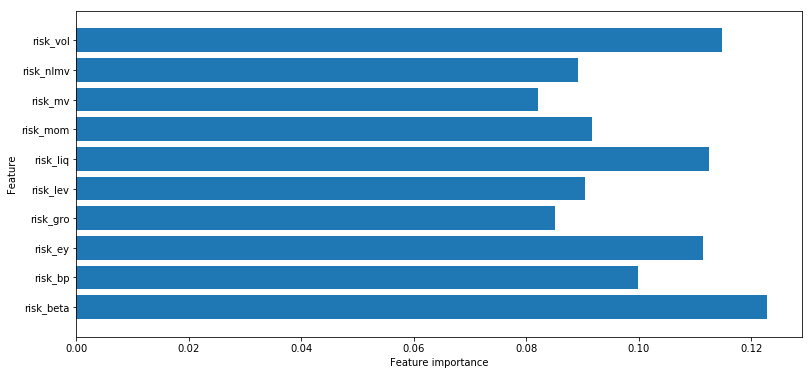

Accuracy of randomforest regressor on train set:0.972
Accuracy of randomforest regressor on test set:0.117


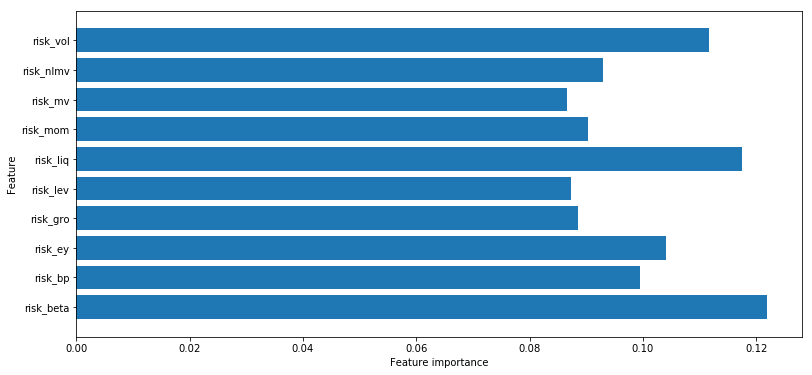

Accuracy of randomforest regressor on train set:0.976
Accuracy of randomforest regressor on test set:0.119


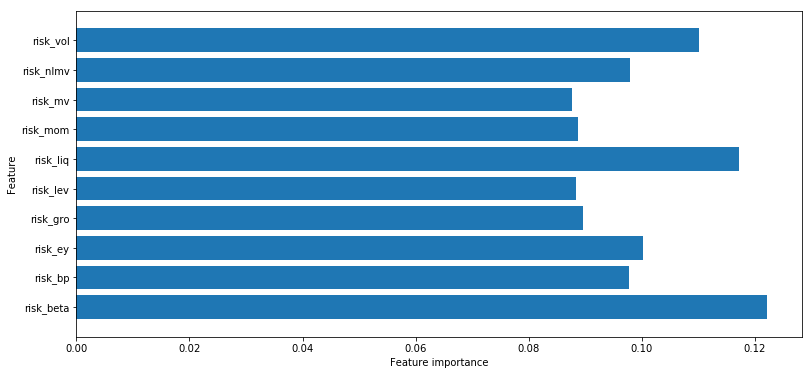

Accuracy of randomforest regressor on train set:0.974
Accuracy of randomforest regressor on test set:0.108


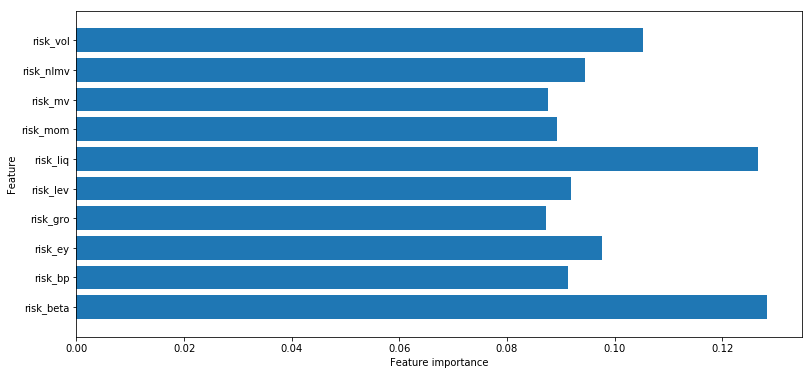

Accuracy of randomforest regressor on train set:0.973
Accuracy of randomforest regressor on test set:0.126


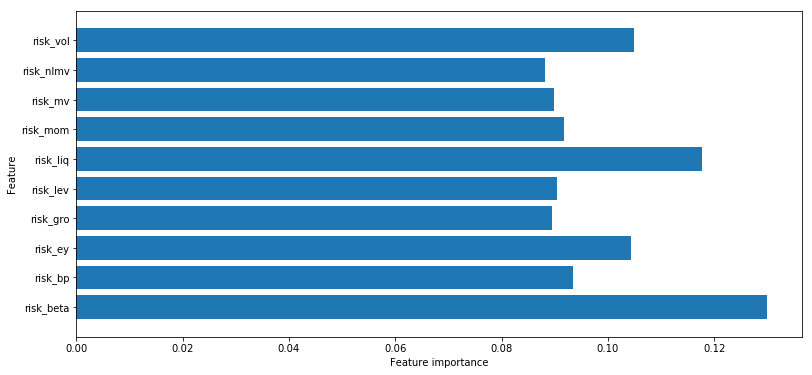

Accuracy of randomforest regressor on train set:0.975
Accuracy of randomforest regressor on test set:0.116


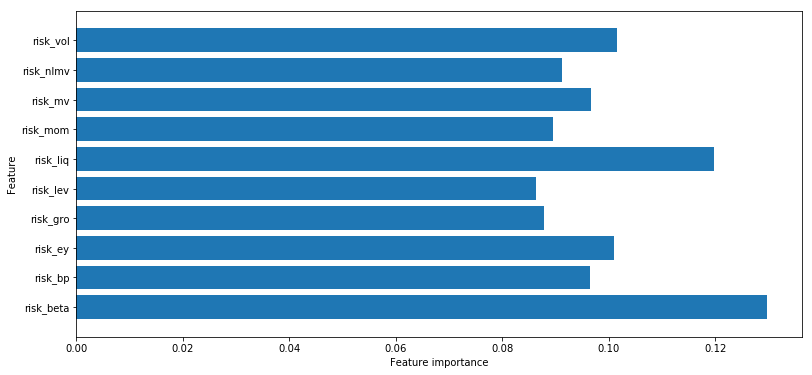

Accuracy of randomforest regressor on train set:0.975
Accuracy of randomforest regressor on test set:0.114


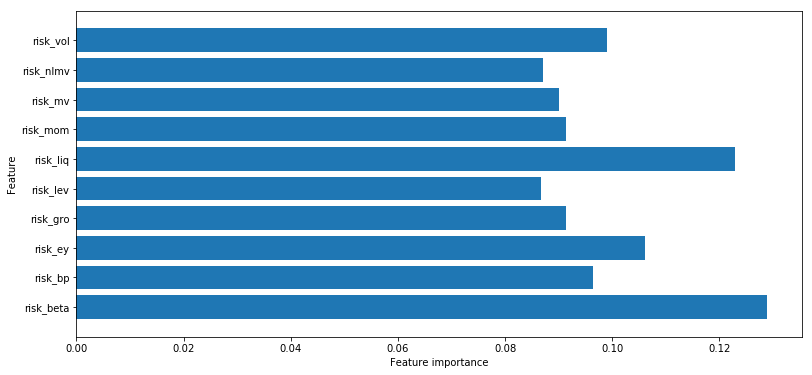

Accuracy of randomforest regressor on train set:0.975
Accuracy of randomforest regressor on test set:0.109


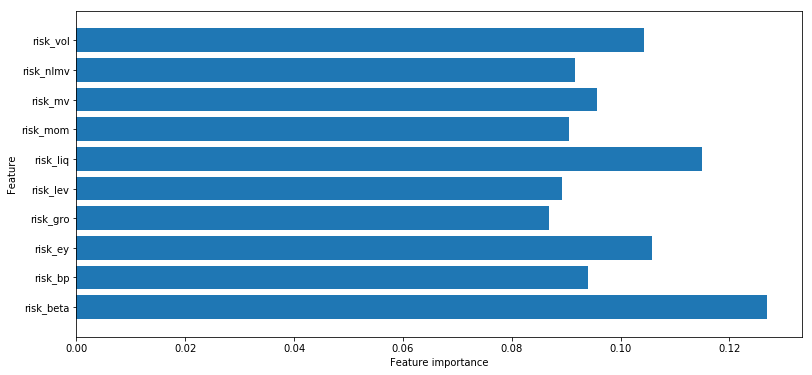

Accuracy of randomforest regressor on train set:0.973
Accuracy of randomforest regressor on test set:0.000


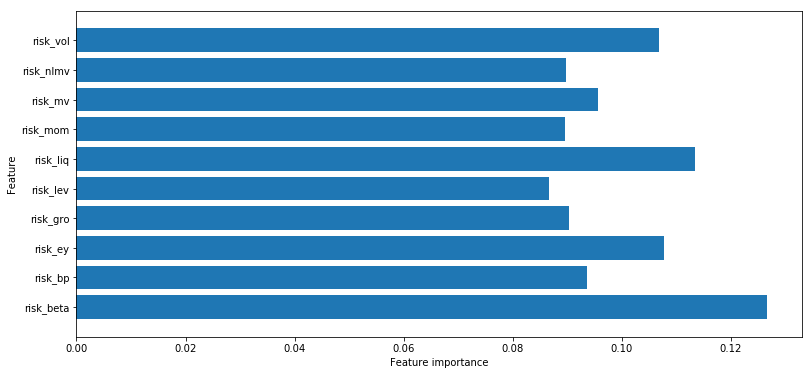

In [129]:
def factor_importance(data_train,data_test)
    for m in range(len(trade_date_m_list)-24):
        X_train, X_test, Y_train, Y_test,Xx_test= Splitdata2(data_train,data_test,m+23,m,m+23,m+24)
        RFC(X_train,Y_train,X_test,Y_test)

#### 因子数据合成

In [56]:
import itertools
date=trade_date_m_list[24:]

def change(data,n,m):
    factor_df=pd.DataFrame(columns=date)
    factor_df['stock']=list(risk_beta_df.index)
    for i,t in itertools.zip_longest(data,date):
        temp=factor_df[['stock']]
        temp[t]=np.nan
        u=i.iloc[:,[n,m]]
        u.columns=[t,'stock']
        factor_Crash=pd.concat([u,temp],join='inner',ignore_index=True)
        factor_Crash.sort_values(t,inplace=True)
        factor_Crash.drop_duplicates(['stock'],inplace=True)
        factor_Crash.sort_values('stock',inplace=True)
        factor_Crash.reset_index(inplace=True)
        factor_df[t]= factor_Crash[t]
    factorF_df=factor_df.set_index(['stock'])
    return factorF_df

def changeindex(data):
    factor0_df=change(data,0,2)
    factor1_df=change(data,1,2)
    return  factor0_df,factor1_df

def changeindex3(data):
    factor0_df=change(data,0,3)
    factor1_df=change(data,1,3)
    factor2_df=change(data,2,3)
    return  factor0_df,factor1_df,factor2_df

In [149]:
# LR_probo10_df

In [54]:
LR_tail10_df,LR_top10_df=changeindex(LR_probo10_df)
LR_tail20_df,LR_top20_df=changeindex(LR_probo20_df)
LR_tail30_df,LR_top30_df=changeindex(LR_probo30_df)

In [111]:
SVM_tail10_df,SVM_top10_df=changeindex(SVM_probo10_df)
SVM_tail20_df,SVM_top20_df=changeindex(SVM_probo20_df)
SVM_tail30_df,SVM_top30_df=changeindex(SVM_probo30_df)

C:\Users\yuanruyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
# lightgbm三分类
lightgbm_pct10_0,lightgbm_pct10_1,lightgbm_pct10_2=changeindex3(lightgbm_probo10_df)
lightgbm_pct20_0,lightgbm_pct20_1,lightgbm_pct20_2=changeindex3(lightgbm_probo20_df)
lightgbm_pct30_0,lightgbm_pct30_1,lightgbm_pct30_2=changeindex3(lightgbm_probo30_df)

C:\Users\yuanruyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [125]:
# lightgbm二分类
lightgbm2_pct10_0,lightgbm2_pct10_1=changeindex(lightgbm2_probo10_df)
lightgbm2_pct20_0,lightgbm2_pct20_1=changeindex(lightgbm2_probo20_df)
lightgbm2_pct30_0,lightgbm2_pct30_1=changeindex(lightgbm2_probo30_df)

C:\Users\yuanruyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### 因子检验

#### 因子显著度T检验

In [136]:
import util.factortool as ftool
def factor_test_T(factor_list,factor_name): 
    risk_test=pd.DataFrame()
    for i ,n in itertools.zip_longest(factor_list,factor_name):
        risk_test[n]=ftool.factor_risk_test_tvalue(i)
    return  risk_test

factor_list=[LR_tail10_df,LR_top10_df,LR_tail20_df,LR_top20_df,LR_tail30_df,LR_top30_df,SVM_tail10_df,SVM_top10_df,SVM_tail20_df,SVM_top20_df,SVM_tail30_df,SVM_top30_df,lightgbm_pct10_0,lightgbm_pct10_1,lightgbm_pct10_2,lightgbm_pct20_0,lightgbm_pct20_1,lightgbm_pct20_2,lightgbm_pct30_0,lightgbm_pct30_1,lightgbm_pct30_2,lightgbm2_pct10_0,lightgbm2_pct10_1,lightgbm2_pct20_0,lightgbm2_pct20_1,lightgbm2_pct30_0,lightgbm2_pct30_1]
factor_name=['LR_tail10_df','LR_top10_df','LR_tail20_df','LR_top20_df','LR_tail30_df','LR_top30_df','SVM_tail10_df','SVM_top10_df','SVM_tail20_df','SVM_top20_df','SVM_tail30_df','SVM_top30_df','lightgbm_pct10_0','lightgbm_pct10_1','lightgbm_pct10_2','lightgbm_pct20_0','lightgbm_pct20_1','lightgbm_pct20_2','lightgbm_pct30_0','lightgbm_pct30_1','lightgbm_pct30_2','lightgbm2_pct10_0','lightgbm2_pct10_1','lightgbm2_pct20_0','lightgbm2_pct20_1','lightgbm2_pct30_0','lightgbm2_pct30_1']

risk_test=factor_test_T(factor_list,factor_name)

In [137]:
risk_test

,LR_tail10_df,LR_top10_df,LR_tail20_df,LR_top20_df,LR_tail30_df,LR_top30_df,SVM_tail10_df,SVM_top10_df,SVM_tail20_df,SVM_top20_df,...,lightgbm_pct20_2,lightgbm_pct30_0,lightgbm_pct30_1,lightgbm_pct30_2,lightgbm2_pct10_0,lightgbm2_pct10_1,lightgbm2_pct20_0,lightgbm2_pct20_1,lightgbm2_pct30_0,lightgbm2_pct30_1
risk_beta,-10.999100,10.999100,2.436777,-2.436777,11.587879,-11.587879,-1.706057,1.706057,3.492650,-3.492650,...,2.991407,7.410613,-6.400139,-0.735517,1.262867,-1.262867,3.285061,-3.285061,4.626699,-4.626699
risk_mv,130.684760,-130.684760,140.116440,-140.116440,126.909205,-126.909205,17.987822,-17.987822,17.948697,-17.948697,...,-1.902786,17.519217,-11.151162,-5.767384,18.068885,-18.068885,17.620080,-17.620080,15.583343,-15.583343
risk_bp,-81.968557,81.968557,-59.730365,59.730365,-44.770566,44.770566,-6.985482,6.985482,-4.496494,4.496494,...,-8.319483,-8.306760,11.891056,-5.290380,-7.847325,7.847325,-5.053064,5.053064,-4.236900,4.236900
risk_mom,-19.052902,19.052902,-35.223557,35.223557,-43.564175,43.564175,-3.009310,3.009310,-5.252355,5.252355,...,9.049472,-0.833934,-6.554693,9.102580,-1.184131,1.184131,-3.564108,3.564108,-4.985295,4.985295
risk_ey,-17.026459,17.026459,-25.081154,25.081154,-33.135704,33.135704,-4.224149,4.224149,-4.190402,4.190402,...,0.595285,-3.647262,1.916737,1.707756,-3.479392,3.479392,-3.623512,3.623512,-4.022420,4.022420
risk_lev,-17.390407,17.390407,-14.383234,14.383234,-16.051464,16.051464,-2.210572,2.210572,-0.758607,0.758607,...,0.614732,0.732200,-0.548882,-0.035924,-0.024703,0.024703,0.649328,-0.649328,0.729948,-0.729948
risk_liq,100.254462,-100.254462,126.891587,-126.891587,135.857492,-135.857492,16.217912,-16.217912,15.623883,-15.623883,...,-5.119643,16.515903,-7.460802,-9.511260,13.314198,-13.314198,15.225536,-15.225536,15.848614,-15.848614
risk_gro,-38.099931,38.099931,-41.553319,41.553319,-42.731865,42.731865,-4.877726,4.877726,-5.650097,5.650097,...,3.667045,-2.194007,-1.403073,4.249715,-1.899760,1.899760,-2.961734,2.961734,-3.926370,3.926370
risk_vol,46.259219,-46.259219,52.230435,-52.230435,48.405769,-48.405769,8.211460,-8.211460,7.698869,-7.698869,...,19.057856,21.444166,-27.411762,9.378168,10.573842,-10.573842,8.367882,-8.367882,6.727866,-6.727866
risk_nlmv,-49.800305,49.800305,-58.099619,58.099619,-66.402005,66.402005,-9.690865,9.690865,-8.704051,8.704051,...,2.558856,-6.539930,3.810380,2.517665,-6.219503,6.219503,-6.286890,6.286890,-6.261959,6.261959


#### 因子保存

In [135]:
# 因子保存
import pickle

LR_tail10_df.to_pickle("./factor_test_data/RISK_TEST/LR_tail10_df")
LR_top10_df.to_pickle("./factor_test_data/RISK_TEST/LR_top10_df")
LR_tail20_df.to_pickle("./factor_test_data/RISK_TEST/LR_tail20_df")
LR_top20_df.to_pickle("./factor_test_data/RISK_TEST/LR_top20_df")
LR_tail30_df.to_pickle("./factor_test_data/RISK_TEST/LR_tail30_df")
LR_top30_df.to_pickle("./factor_test_data/RISK_TEST/LR_top30_df")

SVM_tail10_df.to_pickle("./factor_test_data/RISK_TEST/SVM_tail10_df")
SVM_top10_df.to_pickle("./factor_test_data/RISK_TEST/SVM_top10_df")
SVM_tail20_df.to_pickle("./factor_test_data/RISK_TEST/SVM_tail20_df")
SVM_top20_df.to_pickle("./factor_test_data/RISK_TEST/SVM_top20_df")
SVM_tail30_df.to_pickle("./factor_test_data/RISK_TEST/SVM_tail30_df")
SVM_top30_df.to_pickle("./factor_test_data/RISK_TEST/SVM_top30_df")

lightgbm_pct10_0.to_pickle("./factor_test_data/RISK_TEST/lightgbm_pct10_0")
lightgbm_pct10_1.to_pickle("./factor_test_data/RISK_TEST/lightgbm_pct10_1")
lightgbm_pct10_2.to_pickle("./factor_test_data/RISK_TEST/lightgbm_pct10_2")
lightgbm_pct20_0.to_pickle("./factor_test_data/RISK_TEST/lightgbm_pct20_0")
lightgbm_pct20_1.to_pickle("./factor_test_data/RISK_TEST/lightgbm_pct20_1")
lightgbm_pct20_2.to_pickle("./factor_test_data/RISK_TEST/lightgbm_pct20_2")
lightgbm_pct30_0.to_pickle("./factor_test_data/RISK_TEST/lightgbm_pct30_0")
lightgbm_pct30_1.to_pickle("./factor_test_data/RISK_TEST/lightgbm_pct30_1")
lightgbm_pct30_2.to_pickle("./factor_test_data/RISK_TEST/lightgbm_pct30_2")


lightgbm2_pct10_0.to_pickle("./factor_test_data/RISK_TEST/lightgbm2_pct10_0")
lightgbm2_pct10_1.to_pickle("./factor_test_data/RISK_TEST/lightgbm2_pct10_1")
lightgbm2_pct20_0.to_pickle("./factor_test_data/RISK_TEST/lightgbm2_pct20_0")
lightgbm2_pct20_1.to_pickle("./factor_test_data/RISK_TEST/lightgbm2_pct20_1")
lightgbm2_pct30_0.to_pickle("./factor_test_data/RISK_TEST/lightgbm2_pct30_0")
lightgbm2_pct30_1.to_pickle("./factor_test_data/RISK_TEST/lightgbm2_pct30_1")


In [ ]:
# u=open("./factor_test_data/LR_TEST/factor_Crash_df15","rb+")
# pickle.load(u)

#### 因子测试

In [60]:
import alphafactors.factorprepro_class as fp
import alphafactors.factoranalyse as fa

#因子处理(分成两种方向)
def factor_analyse0(name,factor):  # 0-positive , 1-negetive
    factor_prepro_obj = fp.FactorPrePro(factor_name=name, factor_data_df=factor, universe='ZZ', neutral_list=None)
    factor_prepro_obj.run_process(start_date=max(factor.columns[0], dt.datetime(2007,1,5)), end_date=factor.columns[-1])
    df = factor_prepro_obj.factor_pro_df
    factor_test_obj = fa.FactorAnalyse(factor_name=name, factor_data_df=df, factor_dr=0)   # 0-positive , 1-negetive
    factor_test_obj.run_analyse_new(start_date=dt.datetime(2009,1,23), universe='ZZ')
    return factor_test_obj

def factor_analyse1(name,factor):  # 0-positive , 1-negetive
    factor_prepro_obj = fp.FactorPrePro(factor_name=name, factor_data_df=factor, universe='ZZ', neutral_list=None)
    factor_prepro_obj.run_process(start_date=max(factor.columns[0], dt.datetime(2007,1,5)), end_date=factor.columns[-1])
    df = factor_prepro_obj.factor_pro_df
    factor_test_obj = fa.FactorAnalyse(factor_name=name, factor_data_df=df, factor_dr=1)   # 0-positive , 1-negetive
    factor_test_obj.run_analyse_new(start_date=dt.datetime(2009,1,23), universe='ZZ')
    return factor_test_obj

#因子测试画图显示
def show1(factor_test_obj):
    factor_test_obj.net_value_df.iloc[:,-3:].plot(figsize=(20,10))
def show2(factor_test_obj):
    factor_test_obj.factor_perform_df
    return  factor_test_obj.factor_perform_df
def show3(factor_test_obj):
    factor_test_obj.factor_para_df
    return  factor_test_obj.factor_para_df
def show4(factor_test_obj):
    factor_test_obj.port_perform_df
    return     factor_test_obj.port_perform_df
def show5(factor_test_obj):
    factor_test_obj.port_perform_df['annual_return'].plot(kind='bar')
    return factor_test_obj.port_perform_df['annual_return'].plot(kind='bar')   
def show6(factor_test_obj):
    factor_test_obj.factor_index_df['IC值'].plot(kind='bar', figsize=(20,10), color='blue')
    return  factor_test_obj.factor_index_df['IC值'].plot(kind='bar', figsize=(20,10), color='blue')

C:\Users\yuanruyi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [61]:
LR_tail10_obj=factor_analyse1('LR-1',LR_tail10_df)
LR_top10_obj=factor_analyse0('LR+1',LR_top10_df)
LR_tail20_obj=factor_analyse1('LR-2',LR_tail20_df)
LR_top20_obj=factor_analyse0('LR+1',LR_top20_df)
LR_tail30_obj=factor_analyse1('LR-3',LR_tail30_df)
LR_top30_obj=factor_analyse0('LR+3',LR_top30_df)

因子 LR-1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:56 Time:  0:00:56

| |   #                                              | 89 Elapsed Time: 0:00:10
因子 LR+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:01 Time:  0:01:01

| |                         #                        | 89 Elapsed Time: 0:00:12
因子 LR-2 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:00 Time:  0:01:00

| |     #                                            | 89 Elapsed Time: 0:00:10
因子 LR+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:00 Time:  0:01:00

| |        #                                         | 89 Elapsed Time: 0:00:10
因子 LR-3 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:00 Time:  0:01:00

| |                                            #     | 89 Elapsed Time: 0:00:14
因子 LR+3 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:01 Time:  0:01:01

| |           #               

In [409]:
SVM_tail10_obj=factor_analyse1('SVM-1',SVM_tail10_df)
SVM_top10_obj=factor_analyse0('SVM+1',SVM_top10_df)
SVM_tail20_obj=factor_analyse1('SVM-2',SVM_tail10_df)
SVM_top20_obj=factor_analyse0('SVM+2',SVM_top10_df)
SVM_tail30_obj=factor_analyse1('SVM-3',SVM_tail30_df)
SVM_top30_obj=factor_analyse0('SVM+3',SVM_top30_df)

因子 SVM-1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:54 Time:  0:00:54

| |     #                                            | 89 Elapsed Time: 0:00:09
因子 SVM+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:53 Time:  0:00:53

| |  #                                               | 89 Elapsed Time: 0:00:09
因子 SVM-2 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:54 Time:  0:00:54

| |#                                                 | 89 Elapsed Time: 0:00:09
因子 SVM+2 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:54 Time:  0:00:54

| | #                                                | 89 Elapsed Time: 0:00:10
因子 SVM-3 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:56 Time:  0:00:56

| | #                                                | 89 Elapsed Time: 0:00:10
因子 SVM+3 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:55 Time:  0:00:55

| |           #         

In [138]:
# lightgbm二分类
lightgbm2_pct10_0_obj=factor_analyse1('lightgbm+1',lightgbm2_pct10_0)
lightgbm2_pct10_1_obj=factor_analyse0('lightgbm+1',lightgbm2_pct10_1)
lightgbm2_pct20_0_obj=factor_analyse1('lightgbm+1',lightgbm2_pct20_0)
lightgbm2_pct20_1_obj=factor_analyse0('lightgbm+1',lightgbm2_pct20_1)
lightgbm2_pct30_0_obj=factor_analyse1('lightgbm+1',lightgbm2_pct30_0)
lightgbm2_pct30_1_obj=factor_analyse1('lightgbm+1',lightgbm2_pct30_1)

因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:58 Time:  0:00:58

| |       #                                          | 89 Elapsed Time: 0:00:09
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:57 Time:  0:00:57

| |      #                                           | 89 Elapsed Time: 0:00:09
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:54 Time:  0:00:54

| |  #                                               | 89 Elapsed Time: 0:00:09
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:58 Time:  0:00:58

| |               #                                  | 89 Elapsed Time: 0:00:11
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:05 Time:  0:01:05

| |          #                                       | 89 Elapsed Time: 0:00:11
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:59 Time:  0:0

In [154]:
# industry

In [78]:
# lightgbm三分类
lightgbm_pct10_0_obj=factor_analyse1('lightgbm+1',lightgbm_pct10_0)
lightgbm_pct10_1_obj=factor_analyse0('lightgbm+1',lightgbm_pct10_1)
lightgbm_pct10_2_obj=factor_analyse0('lightgbm+1',lightgbm_pct10_2)

lightgbm_pct20_0_obj=factor_analyse1('lightgbm+1',lightgbm_pct20_0)
lightgbm_pct20_1_obj=factor_analyse0('lightgbm+1',lightgbm_pct20_1)
lightgbm_pct20_2_obj=factor_analyse0('lightgbm+1',lightgbm_pct20_2)

lightgbm_pct30_0_obj=factor_analyse1('lightgbm+1',lightgbm_pct30_0)
lightgbm_pct30_1_obj=factor_analyse1('lightgbm+1',lightgbm_pct30_1)
lightgbm_pct30_2_obj=factor_analyse0('lightgbm+1',lightgbm_pct30_2)

因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:56 Time:  0:00:56

| |     #                                            | 89 Elapsed Time: 0:00:09
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:57 Time:  0:00:57

| |        #                                         | 89 Elapsed Time: 0:00:09
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:00:58 Time:  0:00:58

| |       #                                          | 89 Elapsed Time: 0:00:10
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:00 Time:  0:01:00

| |        #                                         | 89 Elapsed Time: 0:00:10
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:01 Time:  0:01:01

| |                #                                 | 89 Elapsed Time: 0:00:11
因子 lightgbm+1 处理中！

100% (91 of 91) |########################| Elapsed Time: 0:01:01 Time:  0:0

In [75]:
show2(LR_tail10_obj)

,年化收益率,最大回撤,月胜率
long_short,0.003194,0.190908,0.511111
300_hedge,0.019620,0.339690,0.500000
500_hedge,0.037808,0.114294,0.588889


In [76]:
show2(LR_tail20_obj)

,年化收益率,最大回撤,月胜率
long_short,0.016788,0.165316,0.588889
300_hedge,0.012509,0.405755,0.477778
500_hedge,0.030690,0.197188,0.588889


In [77]:
show2(LR_tail30_obj)

,年化收益率,最大回撤,月胜率
long_short,0.030959,0.119500,0.588889
300_hedge,0.022883,0.399648,0.477778
500_hedge,0.042001,0.202324,0.600000


In [147]:
# show1(lightgbm2_pct30_0_obj)

In [90]:
show1(lightgbm_pct30_1_obj)

,年化收益率,最大回撤,月胜率
long_short,-0.003394,0.096405,0.422222
300_hedge,0.035595,0.398757,0.511111
500_hedge,0.061143,0.192175,0.600000


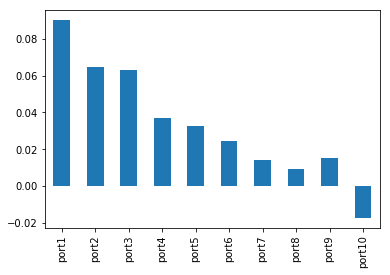

In [100]:
show5(lightgbm_pct30_0_obj)

In [ ]:
# show2(SVM_top10_obj)
# SVM_tail10_obj
# lightgbm_pct10_0

